# CASE BASED CLASSIFICATION

This notebook develops the idea of case base classiication (cb-clf). This involves:
1. Identify sets of feature that provide good classification accuracy. There may be many.
1. Given a new feature vector, provide evidence for the difference classes to which it may belong.

A **feature** is an atribtue of the data, like a Gene. A feature set is a collection of genes.
We typically write this as Rv3246c+Rv3260c.

A **feature vector** is a set of features with a value assigned. We are dealing with trinary values: -1 (under expressed),
+1 (over expressed), 0 (otherwise).
We typically write this as
Rv3246c[-1]+Rv3260c[0].

A **case** is a feature vector that effectively distinguishes between expression states (classes).

Cases are obtained from decision trees by examining nodes to see if their *impurity* (class distinctions) are statistically
significant.

Decision trees are obtained by running the Random Forest Classsification Algorithm.
This is done separately for each expression state.
So, in our data, there are 6 sets of cases.

Classifications are evaluated for new gene expression data by:
* Setup
   1. Construct cases for each expression state.
   
* Evaluation of a data set
   1. Create trinary data
   1. For each expression state
      1. Find applicable cases
      1. Plot their significance level

## Imports

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util
from common import transform_data
from common_python.classifier.feature_set import FeatureSet
from common import trinary_data
from common_python.classifier.cc_case.case_core import FeatureVectorStatistic, Case
from common_python.classifier.cc_case.case_collection import CaseCollection
from common_python.classifier.cc_case.case_multi_collection import CaseMultiCollection
from common_python.classifier.cc_case.case_builder import CaseBuilder
from common_python.classifier.feature_set import FeatureVector

import copy
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

## Constants

In [2]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
PROVIDER = DataProvider()
PROVIDER.do()
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
FEATURES_NAMES = DF_X.columns.tolist()
NUM_TREE = 500
SER_DESC = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
SER_DESC = SER_DESC["GO_Term"]
SERIALIZE_FILE = "case_based_classification.csv"
if os.path.isfile(SERIALIZE_FILE):
    CASE_MULTI_COLLECTION = CaseMultiCollection.deserialize(SERIALIZE_FILE)
else:
    CASE_MULTI_COLLECTION = CaseBuilder.make(DF_X, SER_Y, n_estimators=NUM_TREE)
    CASE_MULTI_COLLECTION.serialize(SERIALIZE_FILE)

In [3]:
len(CASE_MULTI_COLLECTION)

2297

## Data

1. The data consistent of individual replicas of read counts at 26 times.
1. Times are labelled with six states, as defined in ``STATE_DCT``.
1. Raw expression values of normalized w.r.t. time 0 (normal) and transformed as log2 so that there are
25 normalized times that are trinary values defined as:
   * -1 if < -1
   * 1 if > 1
   * 0 otherwise

In [4]:
SER_DESC.head(4)

GENE_ID
P9WKY5                                    host cell nucleus
Rv0001    DNA replication initiation---dephosphorylation...
Rv0002                     extracellular region---cell wall
Rv0003    double-strand break repair---cytosol---plasma ...
Name: GO_Term, dtype: object

In [5]:
sel = [(g in DF_X.columns) and (SER_DESC.loc[g].find("fatty acid") > 0) for g in SER_DESC.index]
SER_DESC[sel]

GENE_ID
Rv0117     regulation of fatty acid metabolic process---r...
Rv0445c    regulation of gene expression---regulation of ...
Rv1359     regulation of gene expression---regulation of ...
Rv1956     response to hypoxia---regulation of fatty acid...
Rv2017     regulation of fatty acid metabolic process---r...
Rv2021c    regulation of fatty acid metabolic process---r...
Rv2034     regulation of transcriptionDNA-templated---reg...
Rv2745c    response to oxidative stress---response to hea...
Rv3133c    response to hypoxia---pathogenesis---regulatio...
Rv3164c    regulation of fatty acid metabolic process---c...
Rv3414c    pathogenesis---response to heat---regulation o...
Rv3416     pathogenesis---regulation of lipid metabolic p...
Rv3557c    regulation of transcriptionDNA-templated---reg...
Rv3833     regulation of fatty acid metabolic process---m...
Name: GO_Term, dtype: object

In [6]:
STATE_DCT = {}
STATE_DCT[0] = "Normoxia"
STATE_DCT[1] = "Transition"
STATE_DCT[2] = "Stage II"
STATE_DCT[3] = "Stage 1a"
STATE_DCT[4] = "Stage 1b"
STATE_DCT[5] = "Resuscitation"
STATE_DCT

{0: 'Normoxia',
 1: 'Transition',
 2: 'Stage II',
 3: 'Stage 1a',
 4: 'Stage 1b',
 5: 'Resuscitation'}

Text(0.5, 1.0, 'State Of Samples')

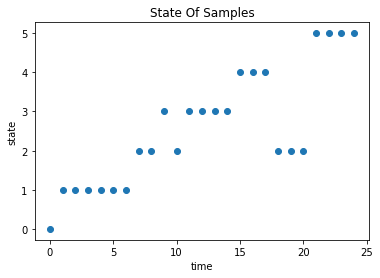

In [7]:
ser_y = SER_Y[SER_Y.index.str.contains("\.0")]
ser_y.index = range(len(ser_y))
plt.scatter(ser_y.index, ser_y.values)
plt.ylabel("state")
plt.xlabel("time")
plt.title("State Of Samples")

In [8]:
SAMPLE_DATA = trinary_data.getSampleData()
DF_AM_MDM = SAMPLE_DATA.AM_MDM.T
DF_AW = SAMPLE_DATA.AW.T
DF_GALAGAN = SAMPLE_DATA.galagan.T
DF_SHERMAN = SAMPLE_DATA.sherman.T
DF_RUSTAD = SAMPLE_DATA.rustad.T

In [9]:
DF_AW

,AW_plus_1,AW_neg_1,AW_plus_3,AW_neg_3,AW_plus_4,AW_neg_4
GENE_ID,,,,,,
Rv1990c,1,1,0,1,1,1
Rv0054,-1,-1,0,-1,-1,0
Rv2488c,-1,-1,-1,-1,-1,-1
Rv1846c,0,0,0,0,0,0
Rv3246c,1,0,0,1,1,1
...,...,...,...,...,...,...
Rv3173c,-1,0,0,0,-1,0
Rv2642,-1,-1,-1,-1,-1,-1
Rv3405c,-1,-1,-1,-1,-1,-1


# Base Cases

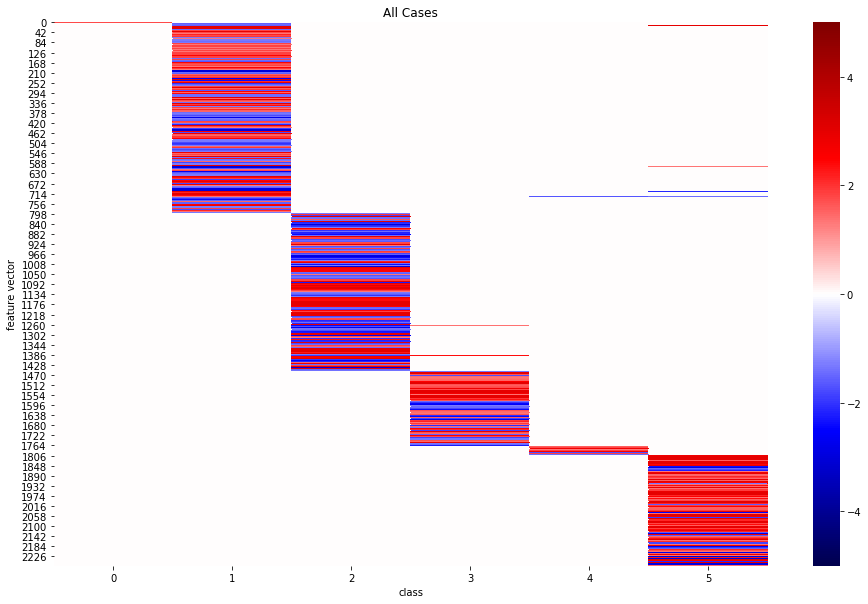

,0,1,2,3,4,5
Rv0767c[0]+Rv3133c[0],1.666497,0.000000,0.0,0.0,0.0,0.000000
Rv1049[0]+Rv3133c[0],1.666497,0.000000,0.0,0.0,0.0,0.000000
Rv2642[0]+Rv3133c[0],1.666497,0.000000,0.0,0.0,0.0,0.000000
Rv3133c[0],1.776676,0.000000,0.0,0.0,0.0,0.000000
Rv0022c[-1]+Rv0081[-1]+Rv1556[0],0.000000,1.343492,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...
Rv3416[1],0.000000,0.000000,0.0,0.0,0.0,2.496101
Rv3830c[-1],0.000000,0.000000,0.0,0.0,0.0,-2.801666
Rv3830c[0],0.000000,0.000000,0.0,0.0,0.0,2.439340
Rv3833[0]+Rv3849[1],0.000000,0.000000,0.0,0.0,0.0,1.373706


In [14]:
CASE_MULTI_COLLECTION.plotHeatmap(title="All Cases", figsize=(16, 10))

## Helper Functions

In [12]:
 def oldFullProfile(ser_X, title="", max_sl=0.001, **kwargs):
        """
        Creates a classification profile for the feature vector.
        
        Parameters
        ----------
        ser_X: Series (feature vector)
        """
        kwargs["max_sl"] = max_sl
        num_row = 2 
        num_col = 3 
        fig, axes = plt.subplots(num_row, num_col,
            figsize=(16, 10))
        for idx, state in enumerate(STATES):
            row = int(idx/num_col)
            col = idx % num_col
            manager = CASE_MANAGER_DCT[state]
            if row == 0:
                label_xoffset = -0.1
            else:
                label_xoffset = 0.1 
            cases = manager.plotEvaluate(ser_X, 
                ax=axes[row, col], is_plot=False,
                title = STATE_DCT[idx],
                label_xoffset=label_xoffset, **kwargs)
        fig.suptitle(title, fontsize=16)
        plt.show()

In [ ]:
def oldfullProfile(collection, ser_X, title="", max_sl=5, include_terms=None, **kwargs):
    """
    Creates a classification profile for the feature vector.

    Parameters
    ----------
    ser_X: Series (feature vector)
    """
    kwargs["max_sl"] = max_sl
    if include_terms is not None:
        for manager in collection.manager_dct.values():
            manager.filterCaseByDescription(ser_desc, include_terms=terms)
    df = collection.plotHeatmap(is_plot=True, **kwargs)

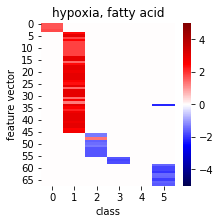

In [69]:
def fullProfile(ser_X, title="", terms=["hypoxia", "fatty acid"], **kwargs):
    """
    Creates a classification profile for the feature vector.

    Parameters
    ----------
    ser_X: Series (feature vector)
    
    Returns
    -------
    pd.DataFrame
        columns: class
        index: FeatureVector
        values: num_zero
    """
    feature_vector = FeatureVector.make(ser_X)
    if terms is None:
        multi= CASE_MULTI_COLLECTION
    else:
        multi = CASE_MULTI_COLLECTION.select(CaseCollection.selectByDescription, ser_desc=SER_DESC, terms=terms)
    df = multi.plotHeatmap(feature_vector=feature_vector, title=title, **kwargs)
# TESTING
ser_X = DF_X.loc["T2.1"]
terms = ["hypoxia", "fatty acid"]
fullProfile(ser_X, figsize=(3,3), terms=["hypoxia"], title=", ".join(terms))

# Miscellaneous Calculations

## Case Calculations

Given a maximum significance level $\alpha$, a sample size of $N$, and null distribution that is Binomial in $(N, p)$,
what is the minimum sample size?

We want $N$ such that $P(n = N) = P(n = 0) \leq \alpha$.
That is, $\alpha \geq p^N \equiv \frac{log(\alpha)}{log(p)} \leq N$.

# Evaluations of Samples - Only "fatty acid" + "hypoxia"

In [21]:
axes

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f52ab0ff8d0>,
       dtype=object))

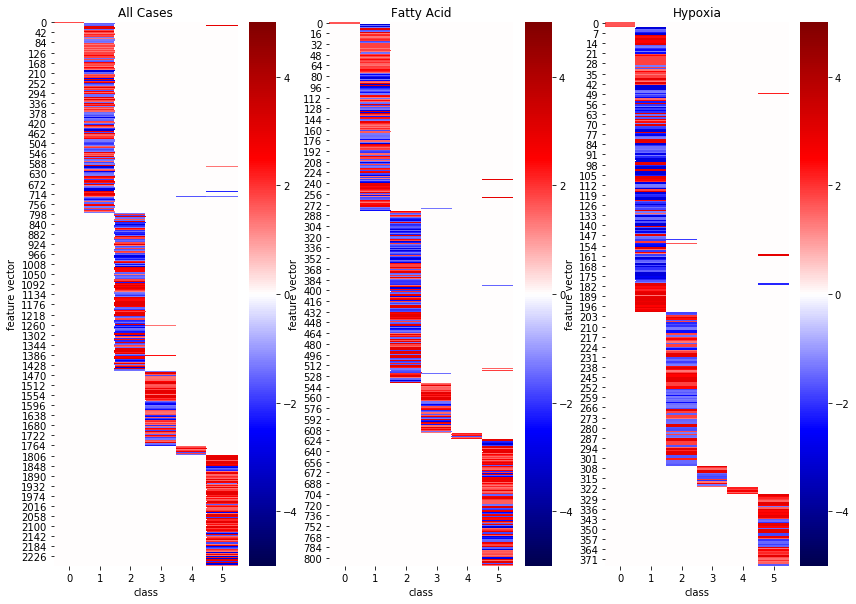

In [47]:
_, axes = plt.subplots(1,3, figsize=(14, 10))
CASE_MULTI_COLLECTION.plotHeatmap(title="All Cases", ax=axes[0], is_plot=False)
multi = CASE_MULTI_COLLECTION.select(CaseCollection.selectByDescription, ser_desc=SER_DESC, terms=["fatty acid"])
multi.plotHeatmap(title="Fatty Acid", ax=axes[1], is_plot=False)
multi1 = CASE_MULTI_COLLECTION.select(CaseCollection.selectByDescription, ser_desc=SER_DESC, terms=["hypoxia"])
multi1.plotHeatmap(title="Hypoxia", ax=axes[2], is_plot=False)
plt.show()

## Training Data

A feature vector evaluation involves finding all cases that apply to the feature vector
and indicating their support for or against a particular state.

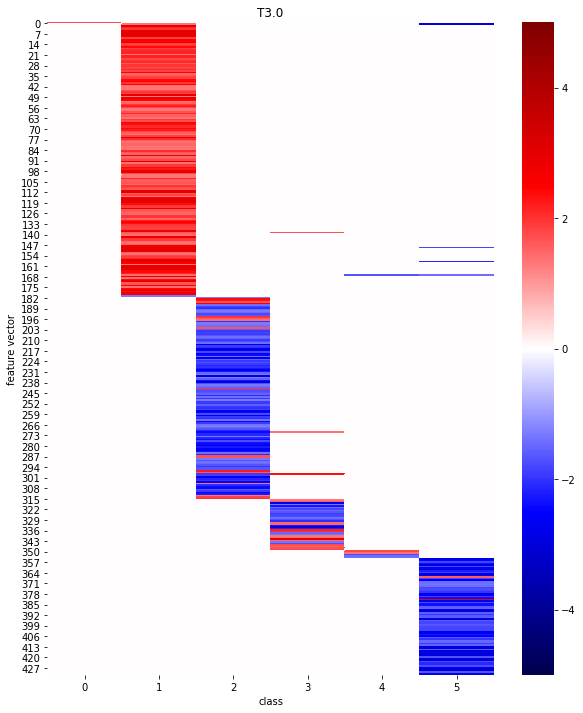

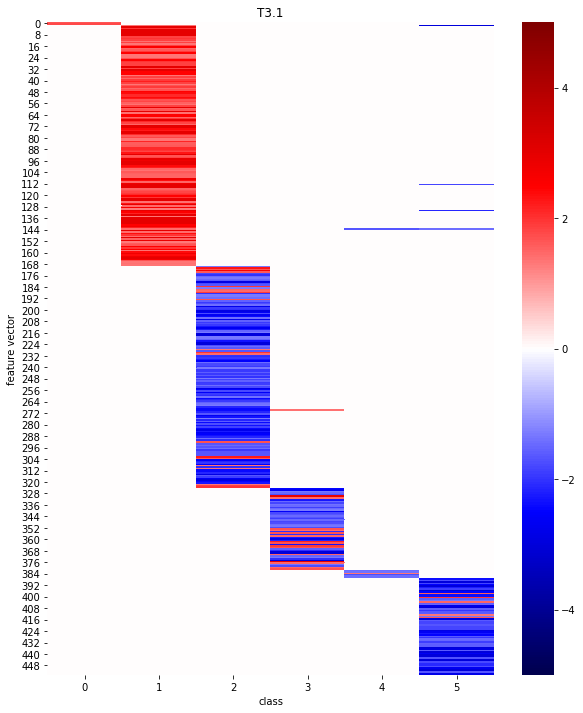

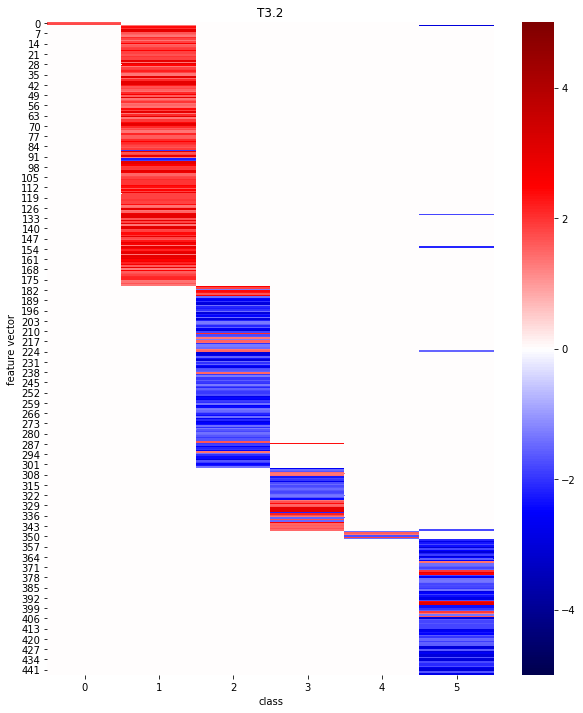

In [67]:
# Below is a evaluation of the feature vector at the first replication at time T3.
instances = ["T3.0", "T3.1", "T3.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

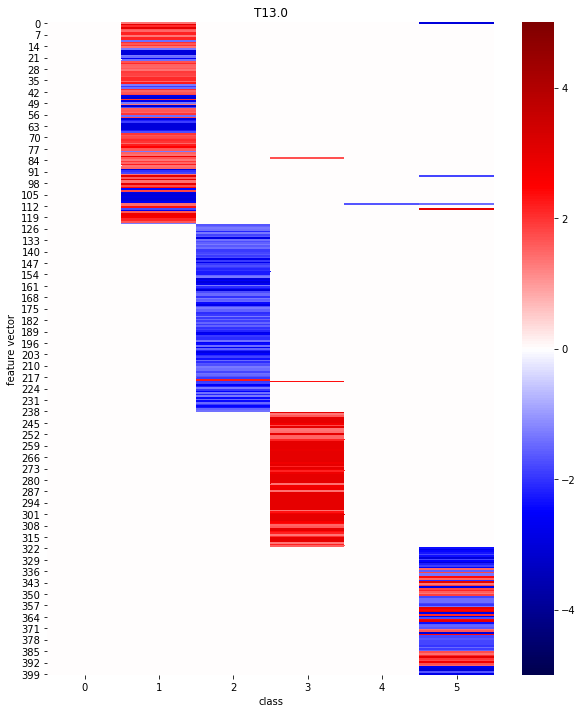

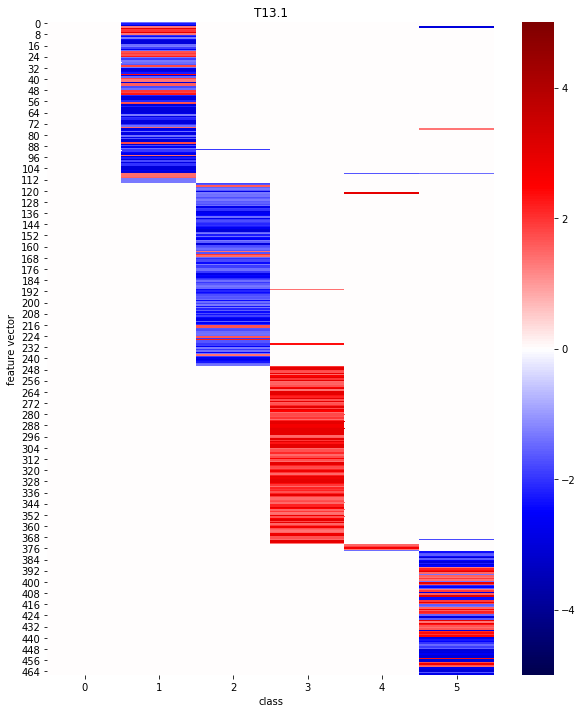

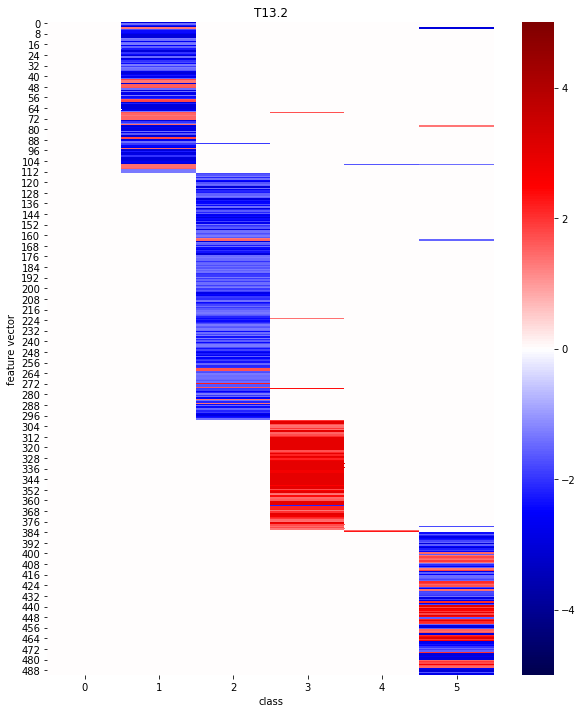

In [49]:
instances = ["T13.0", "T13.1", "T13.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

## AW

In [50]:
DF_AW.head(2)

,AW_plus_1,AW_neg_1,AW_plus_3,AW_neg_3,AW_plus_4,AW_neg_4
GENE_ID,,,,,,
Rv1990c,1,1,0,1,1,1
Rv0054,-1,-1,0,-1,-1,0


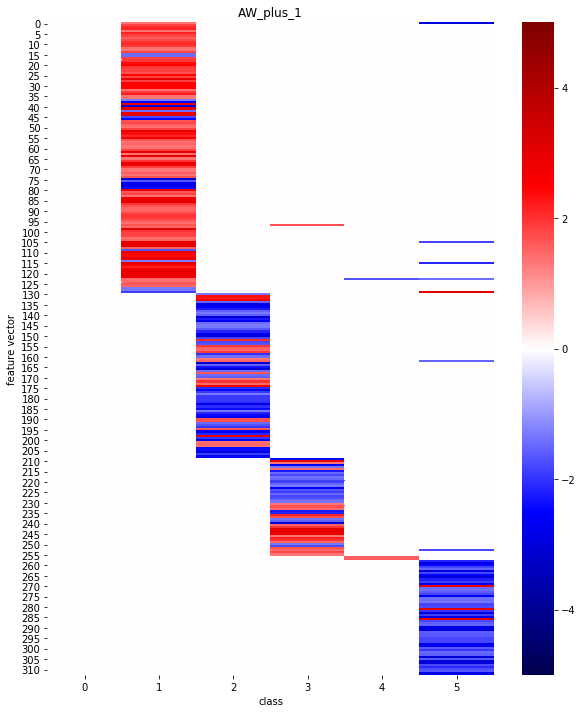

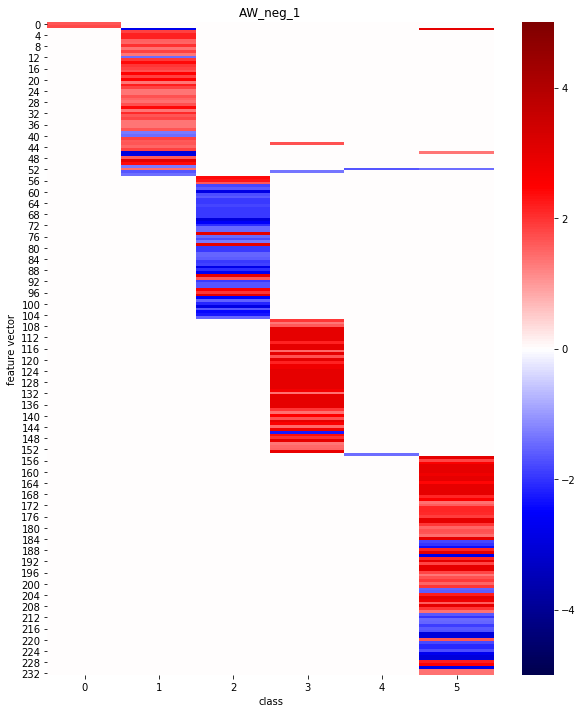

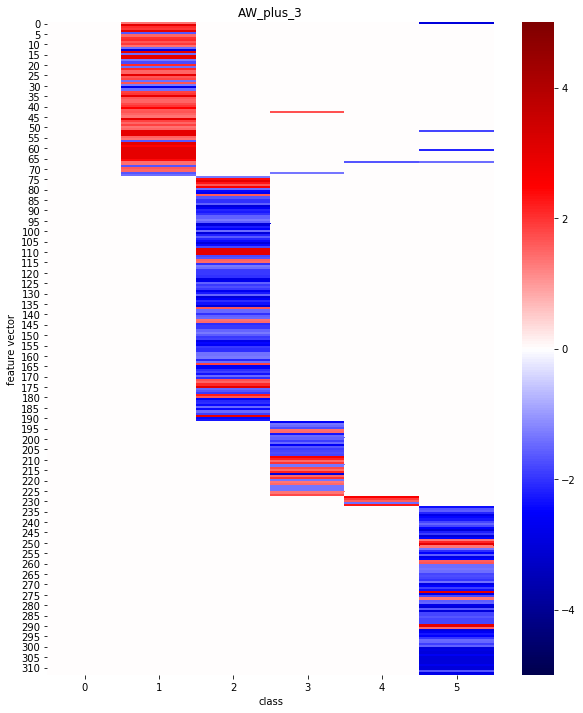

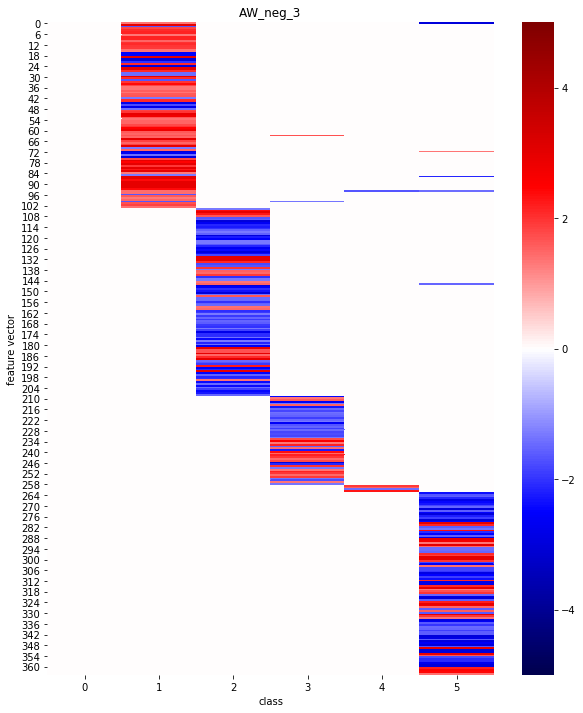

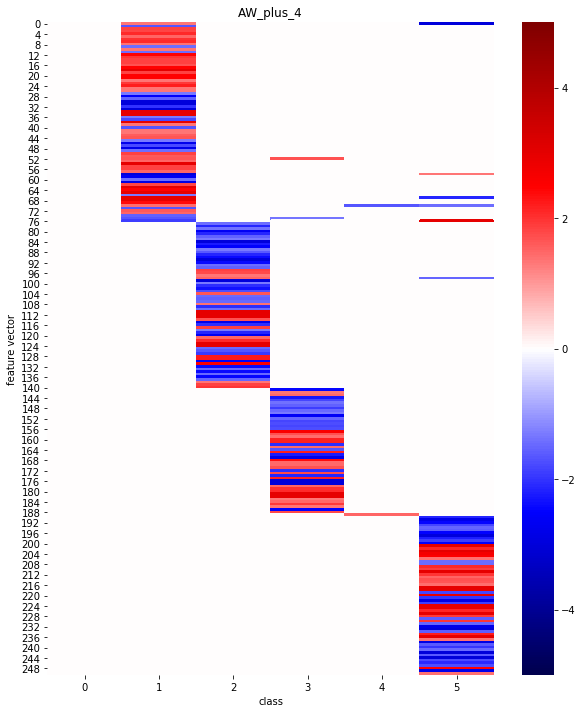

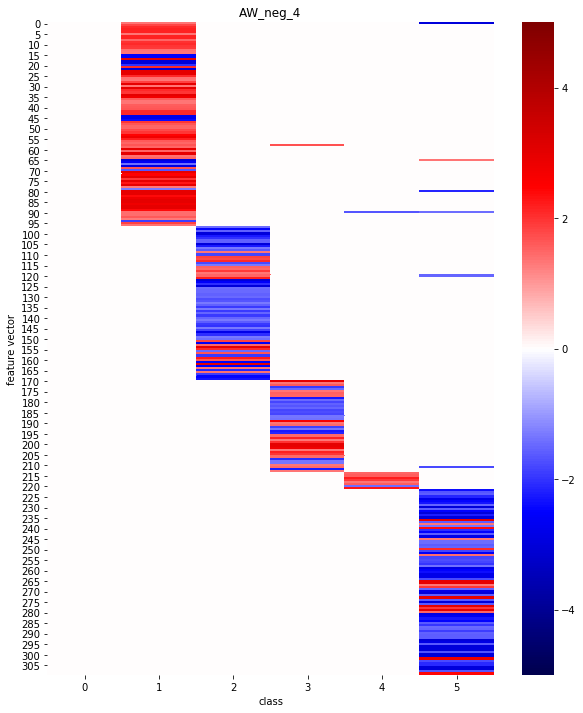

In [77]:
instances = [ ["AW_%s_%d" % (pm, n) for pm in ["plus", "neg"]] for n in [1, 3, 4]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AW[instance], title=instance, terms=None)

## AM, MDM

In [52]:
DF_AM_MDM.head(2)

,AM_D20_1,AM_D20_3,AM_D20_4,AM_D20_5,MDM_D20_1,MDM_D20_3,MDM_D20_4,MDM_D20_5
GENE_ID,,,,,,,,
Rv1990c,1,1,1,1,1,1,1,-1
Rv0054,-1,-1,-1,-1,0,-1,0,-1


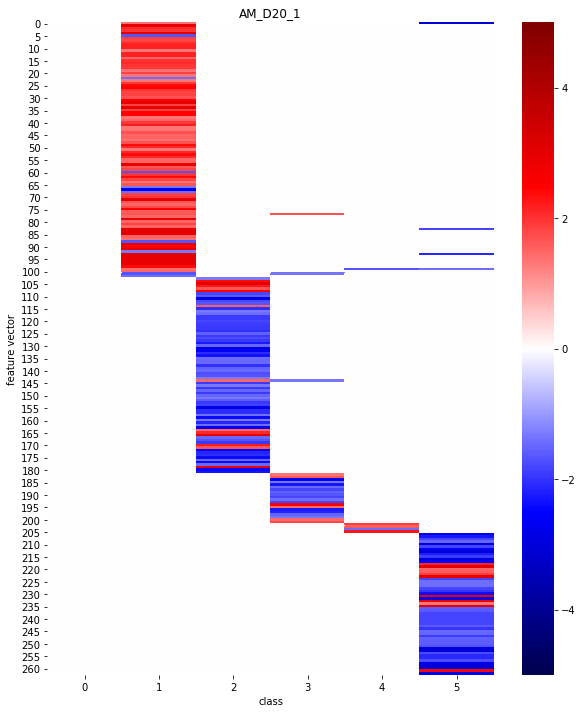

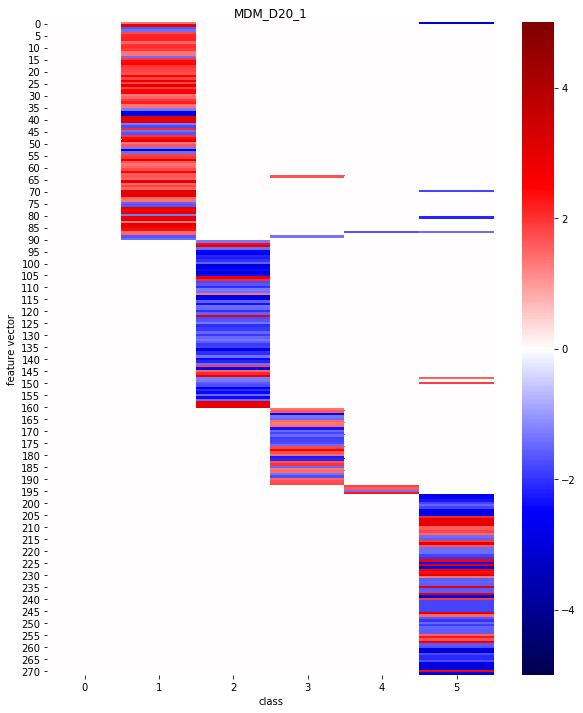

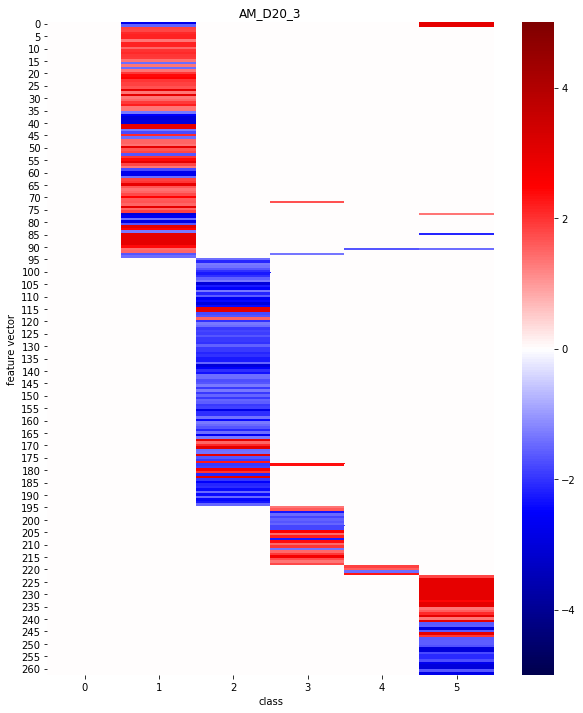

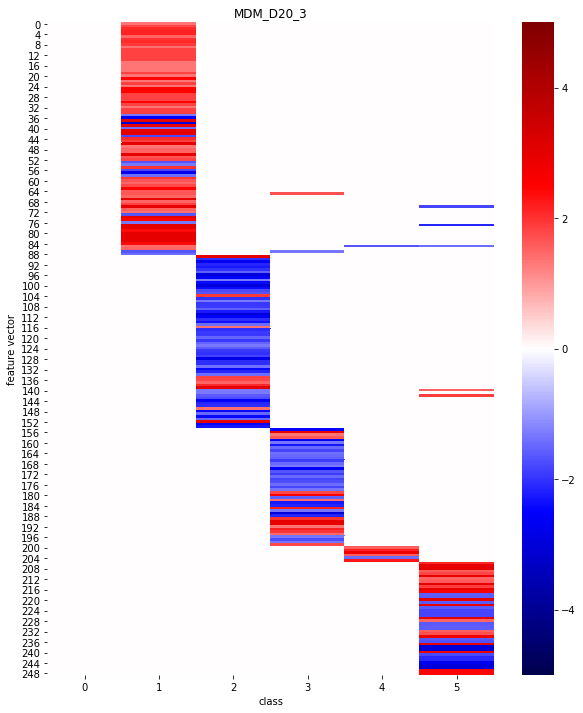

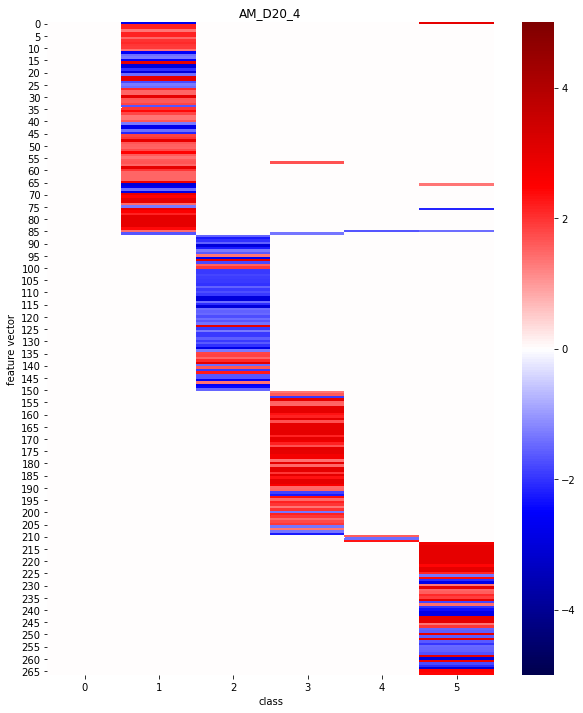

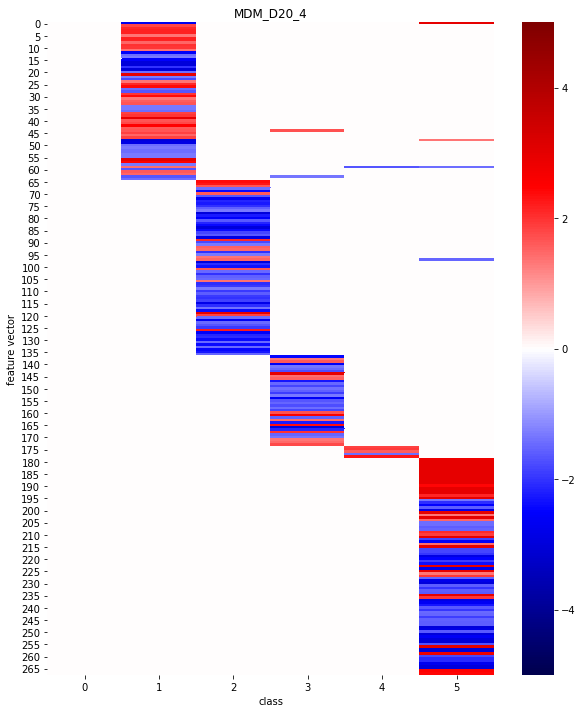

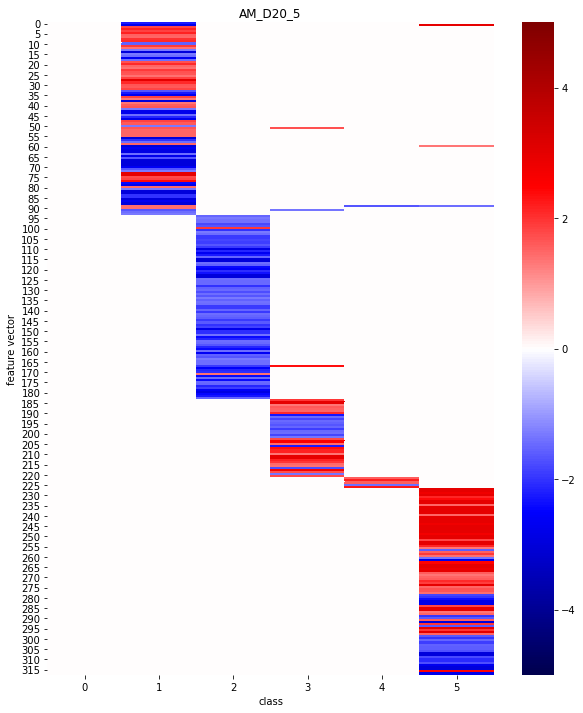

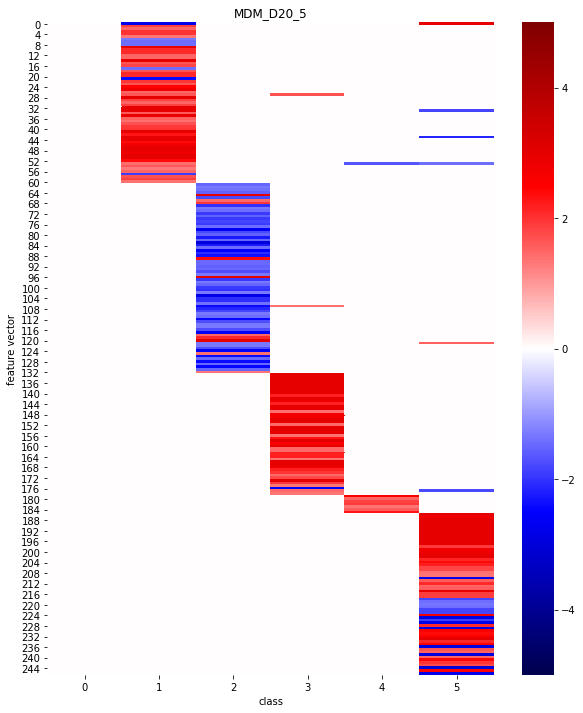

In [53]:
instances = [ ["%s_D20_%d" % (pm, n) for pm in ["AM", "MDM"]] for n in [1, 3, 4, 5]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AM_MDM[instance], title=instance)

## Galagan

In [54]:
DF_GALAGAN.head(2)

,d1.rep1,d2.rep1,d3.rep1,d5.rep1,d7.rep1,d8.rep1,d1.rep2,d2.rep2,d3.rep2,d5.rep2,d7.rep2,d8.rep2,d1.rep3,d2.rep3,d3.rep3,d5.rep3,d7.rep3,d8.rep3
GENE_ID,,,,,,,,,,,,,,,,,,
Rv1990c,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,1,1
Rv0054,0,0,0,0,0,1,0,1,0,0,0,1,-1,0,0,0,0,1


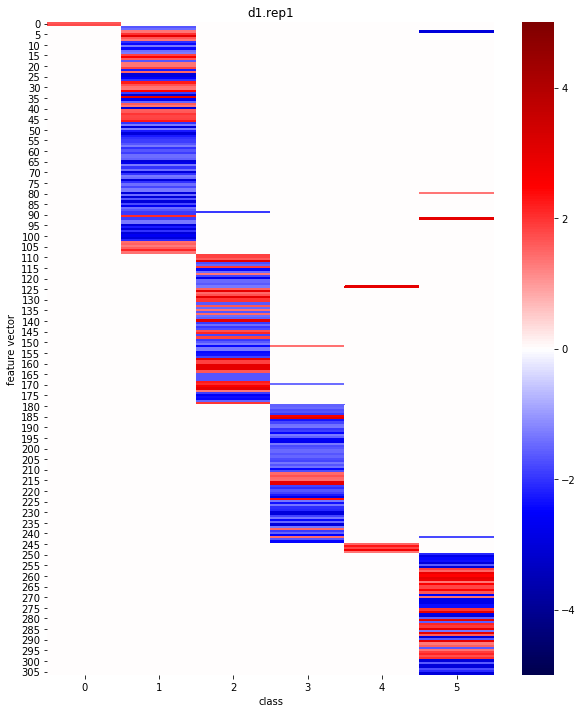

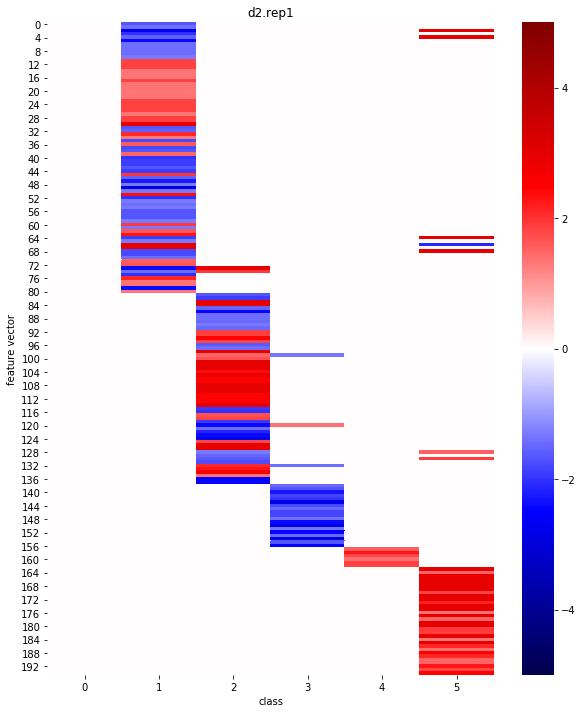

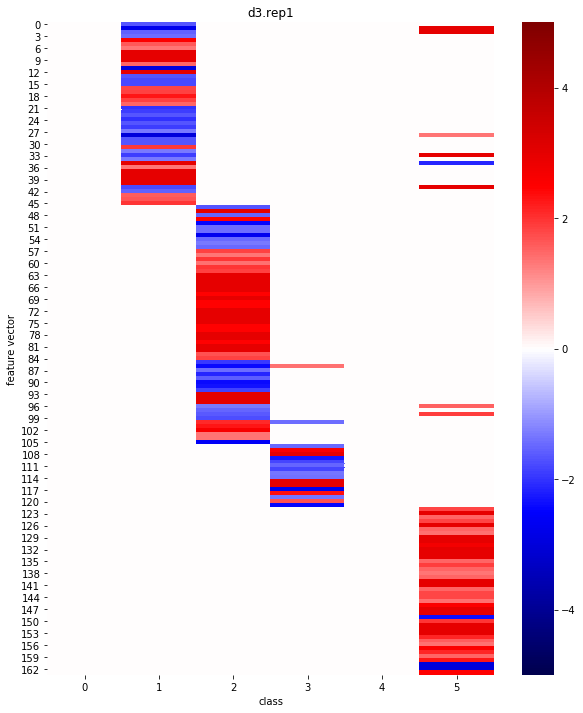

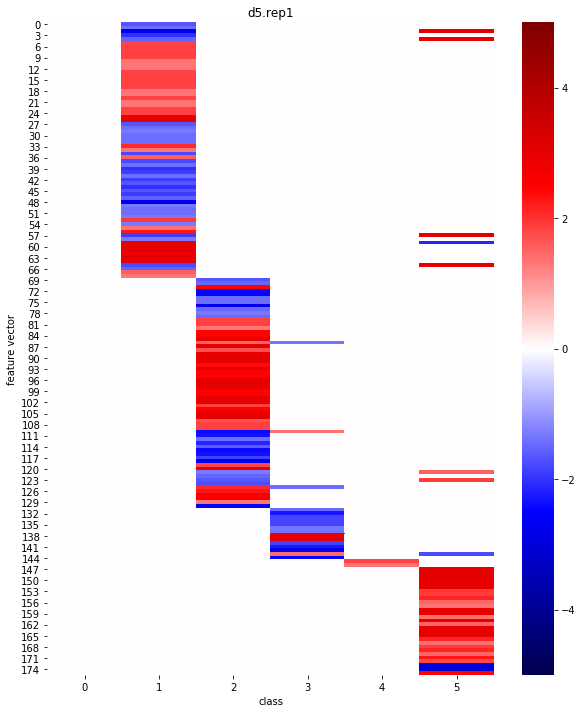

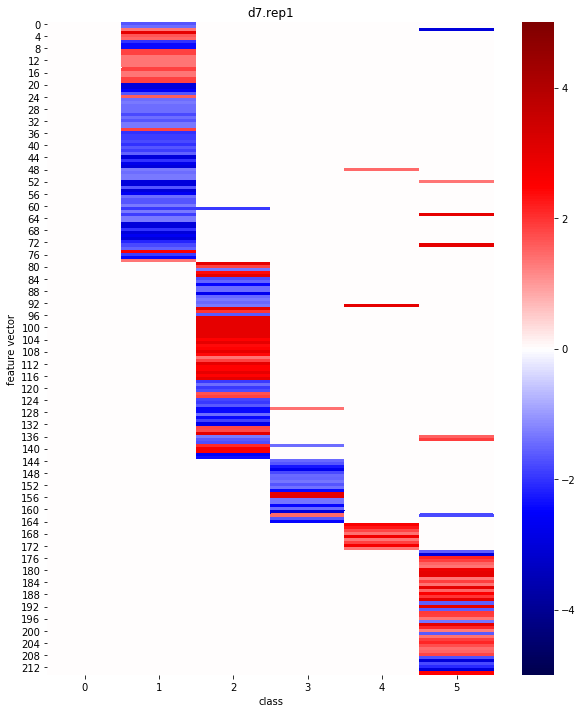

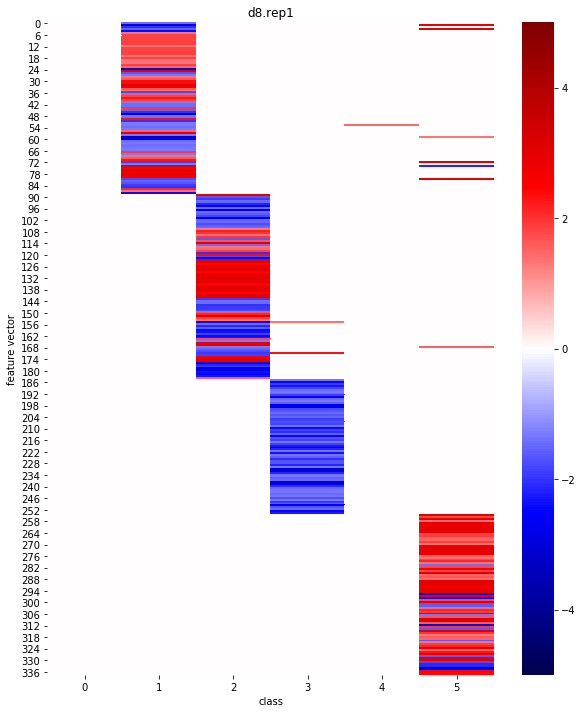

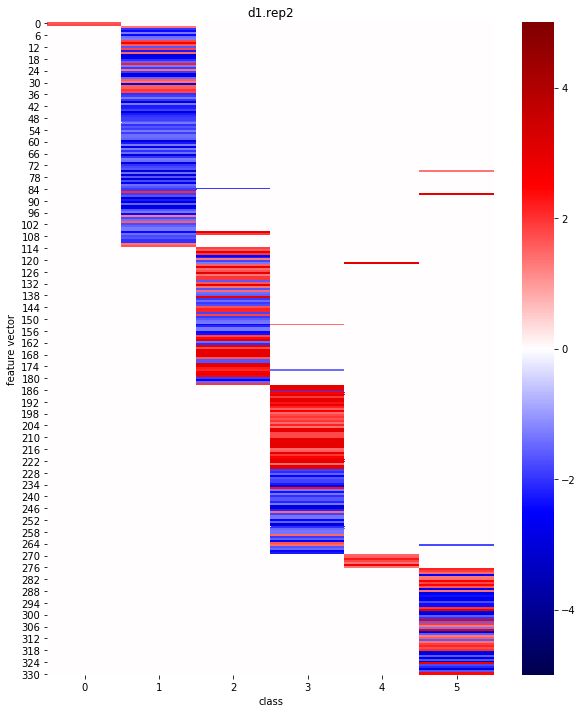

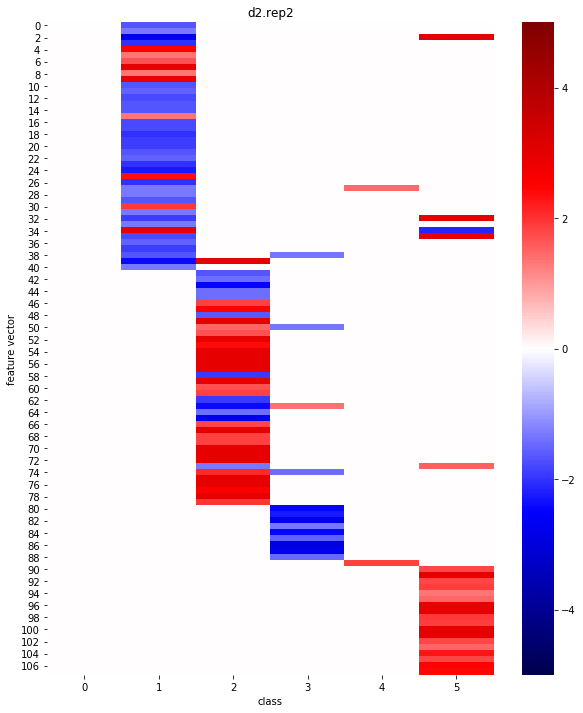

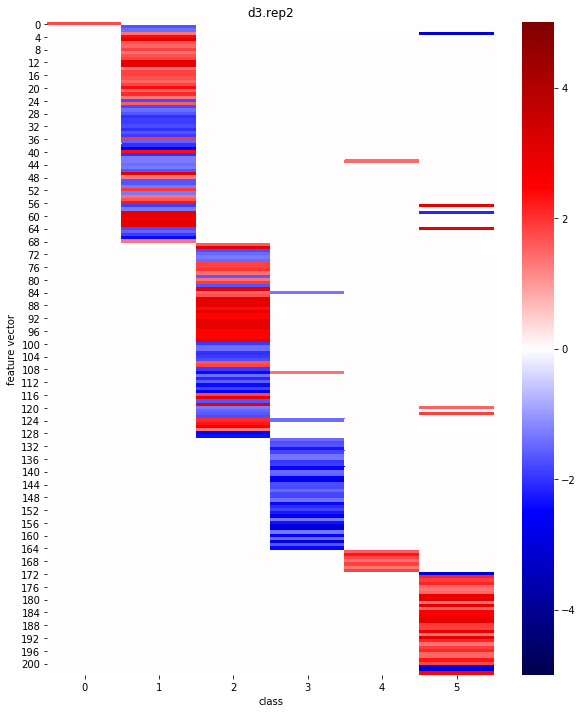

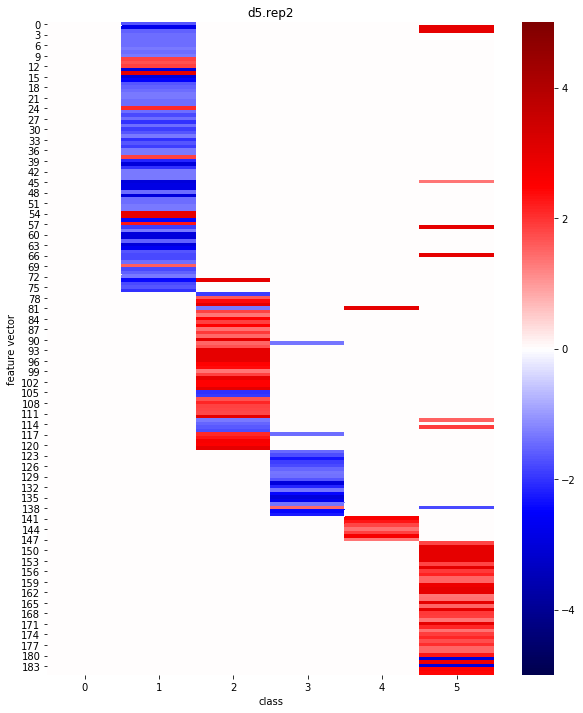

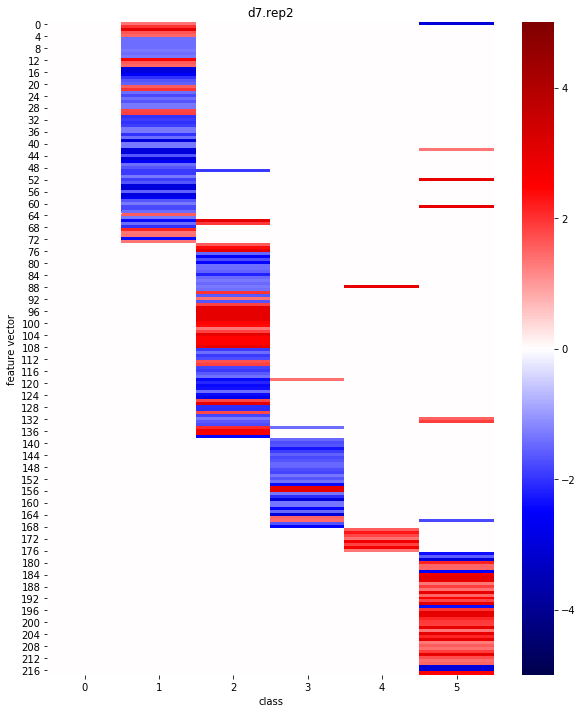

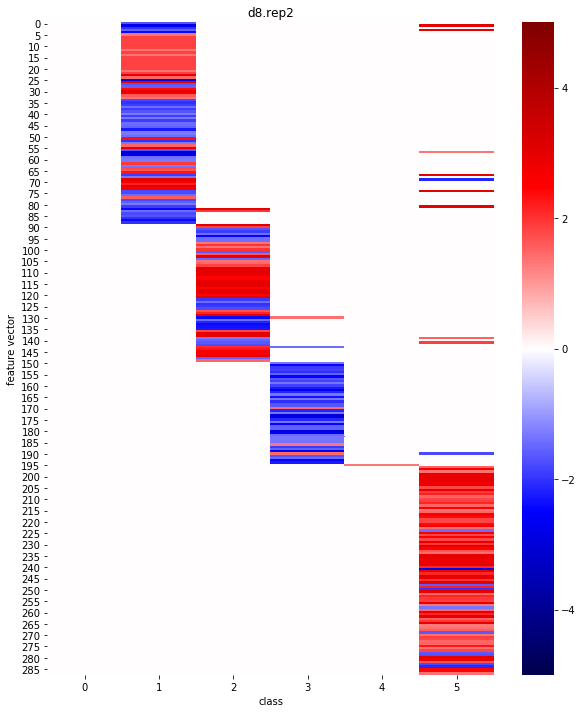

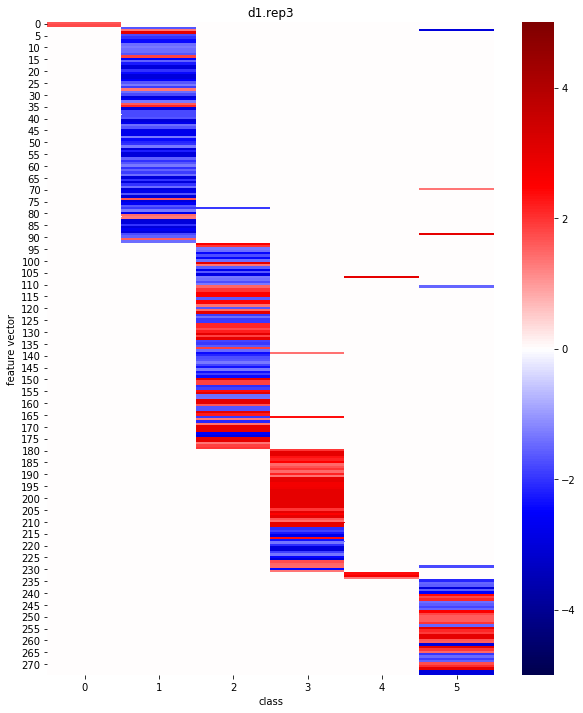

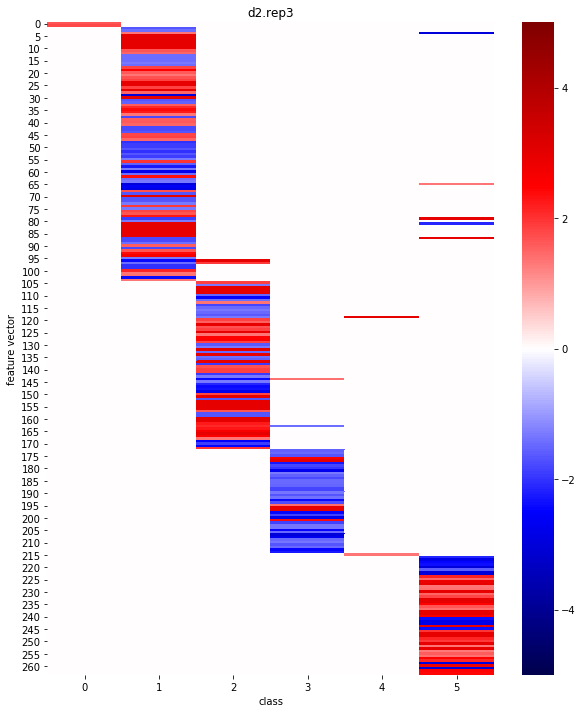

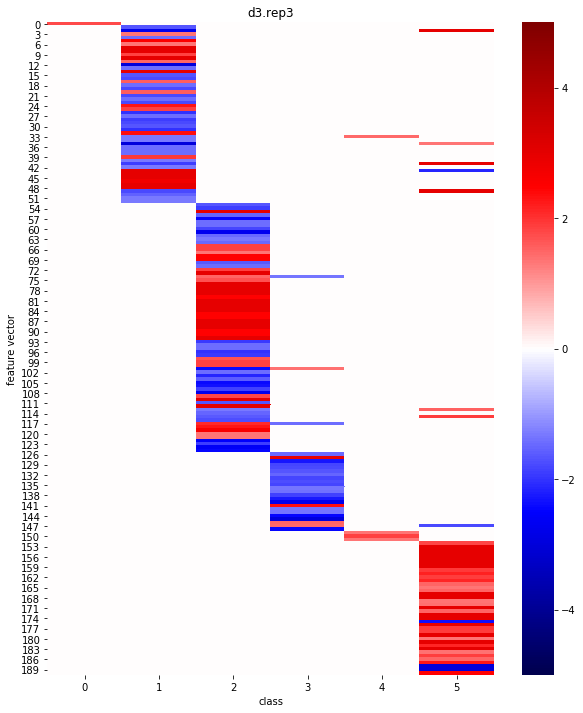

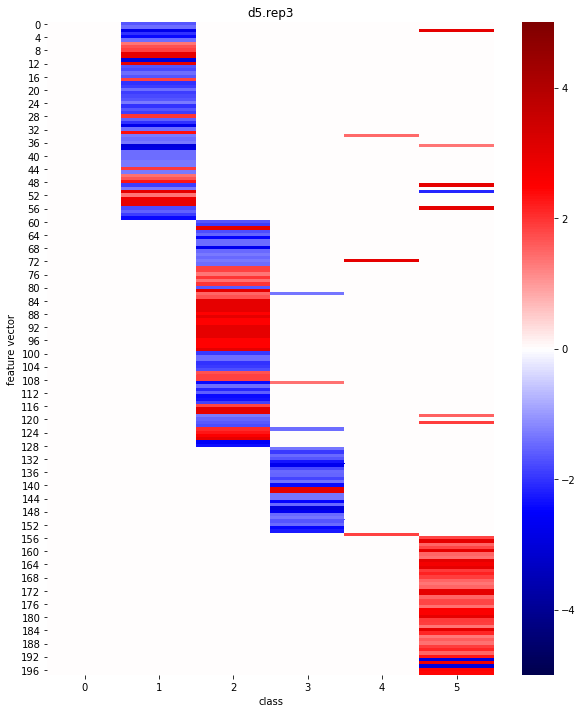

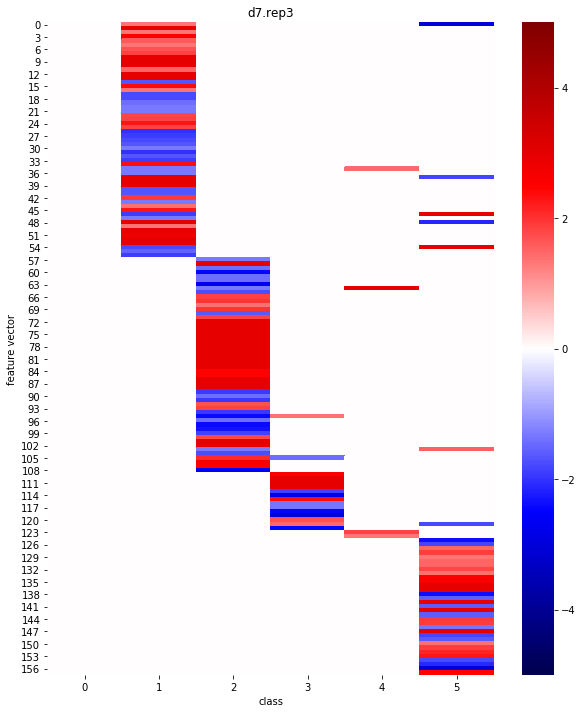

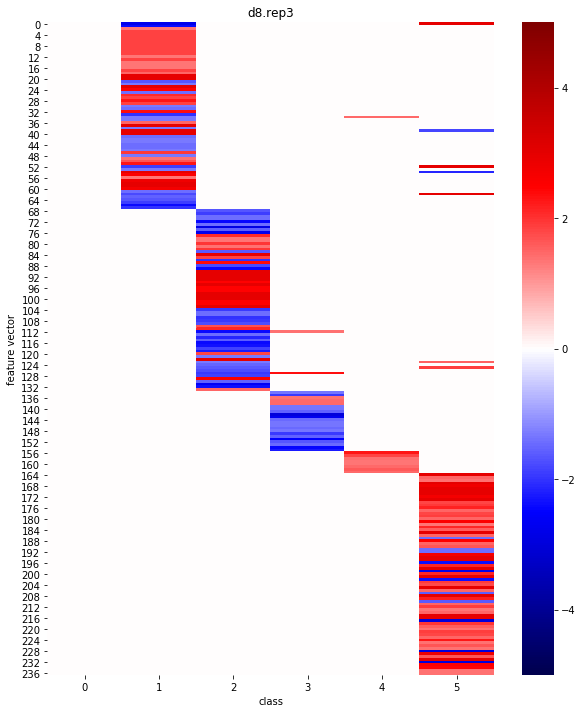

In [55]:
for instance in DF_GALAGAN.columns:
    fullProfile(DF_GALAGAN[instance], title=instance)

## Sherman

In [56]:
DF_SHERMAN.head(2)

,0
Rv1990c,0
Rv0054,-1


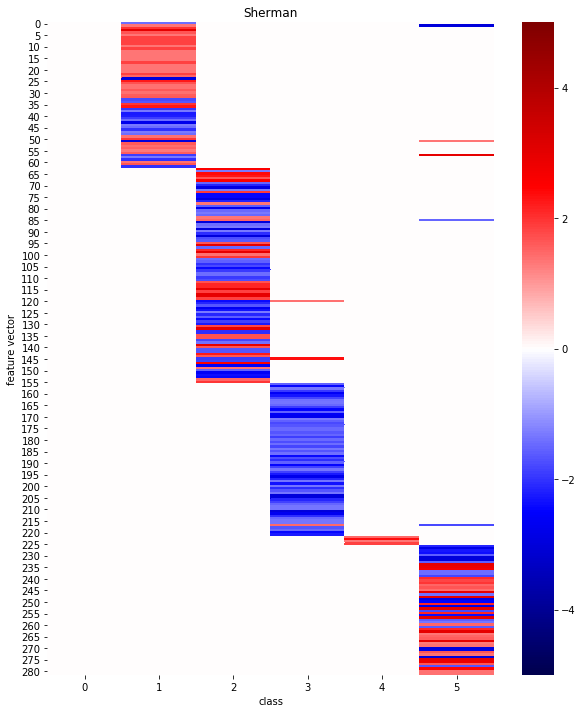

In [57]:
fullProfile(DF_SHERMAN[0], title="Sherman")

## Rustad

In [58]:
DF_RUSTAD.head(2)

,H37Rv_hypoxia_4hr_rep1,H37Rv_hypoxia_4hr_rep2,H37Rv_hypoxia_4hr_rep4,H37Rv_hypoxia_4hr_rep5,H37Rv_hypoxia_4hr_rep6,H37Rv_hypoxia_8hr_rep1,H37Rv_hypoxia_8hr_rep2,H37Rv_hypoxia_12hr_rep1,H37Rv_hypoxia_12hr_rep2,H37Rv_hypoxia_1day_rep2,...,H37Rv_hypoxia_4hr_rep6.1,H37Rv_hypoxia_8hr_rep3,H37Rv_hypoxia_12hr_rep3,H37Rv_hypoxia_1day_rep4,H37Rv_hypoxia_1day_rep10,H37Rv_hypoxia_4day_rep1,H37Rv_hypoxia_4day_rep3,H37Rv_hypoxia_7day_rep4,H37Rv_hypoxia_7day_rep2,H37Rv_hypoxia_7day_rep3
Rv1990c,1,1,1,1,1,1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,1,-1,1
Rv0054,-1,-1,1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,1,1,-1,1,-1


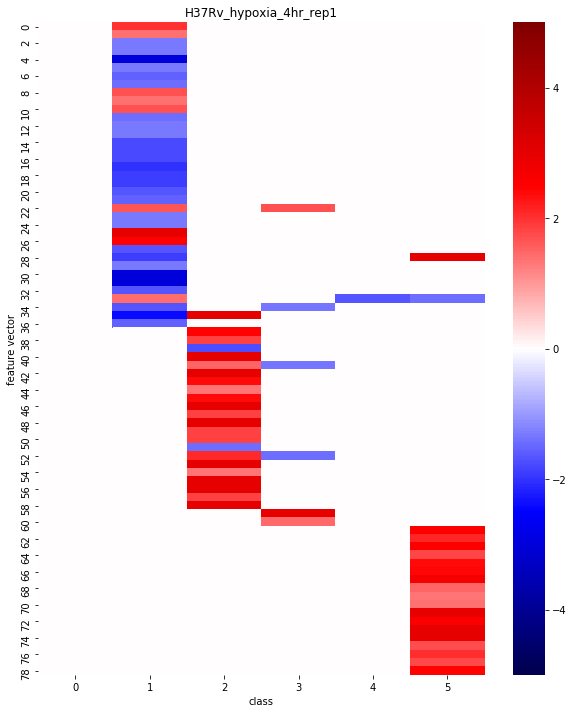

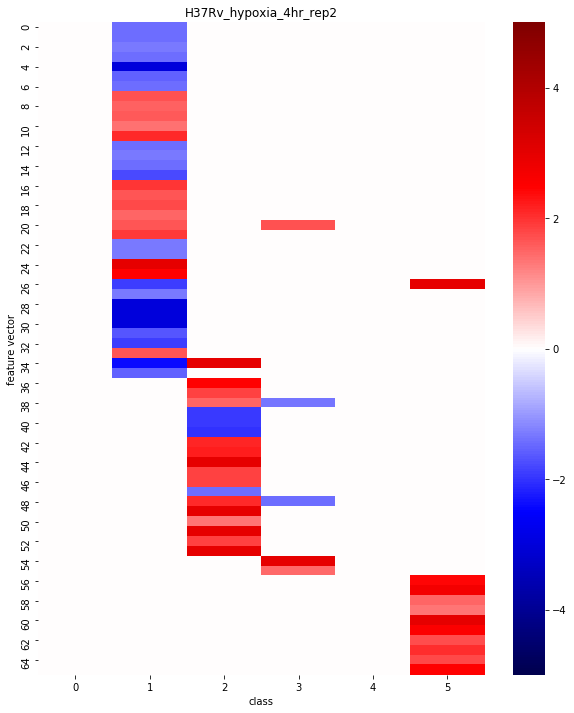

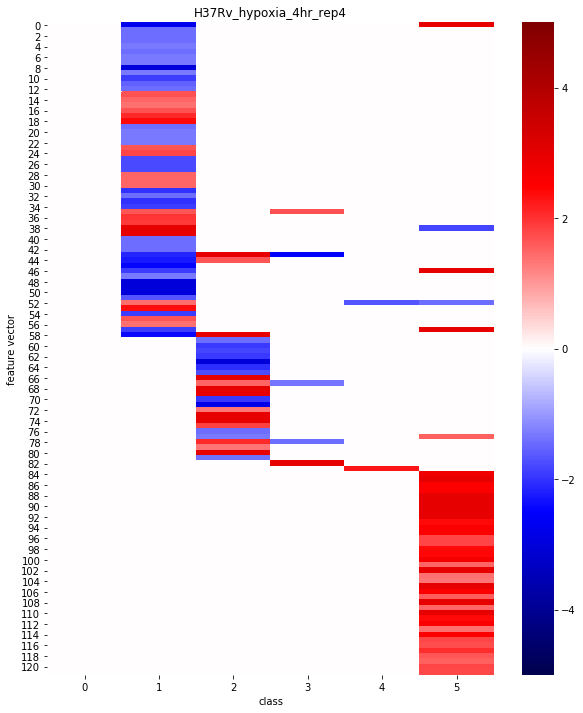

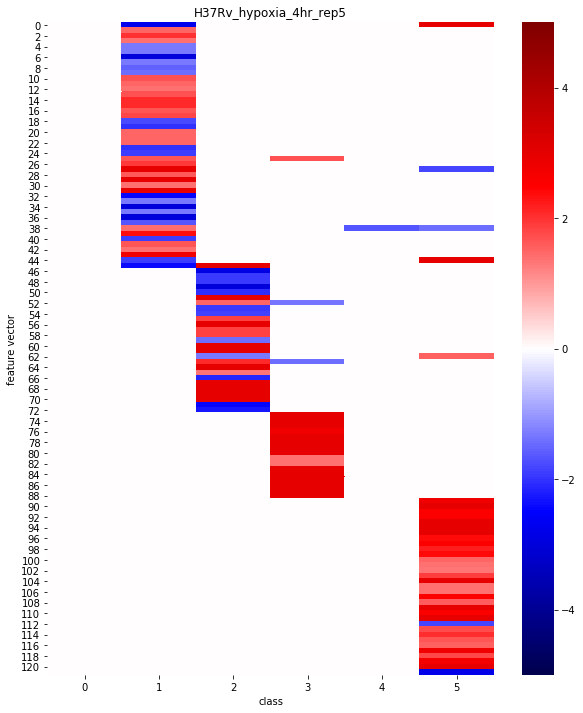

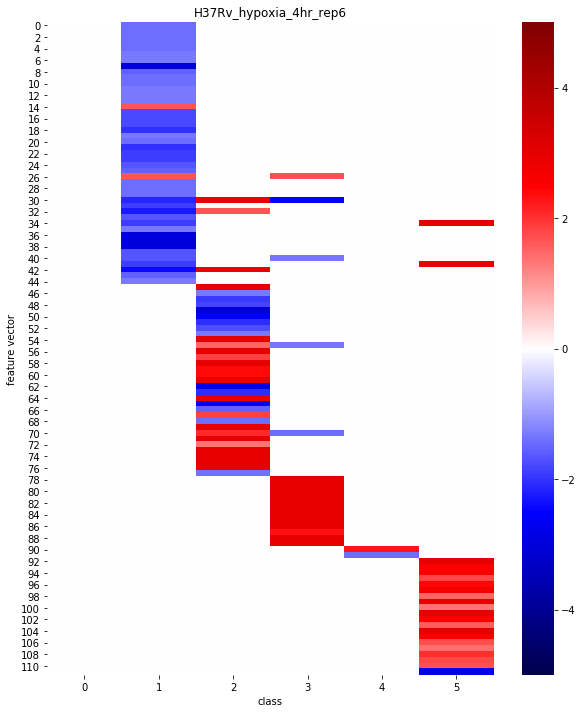

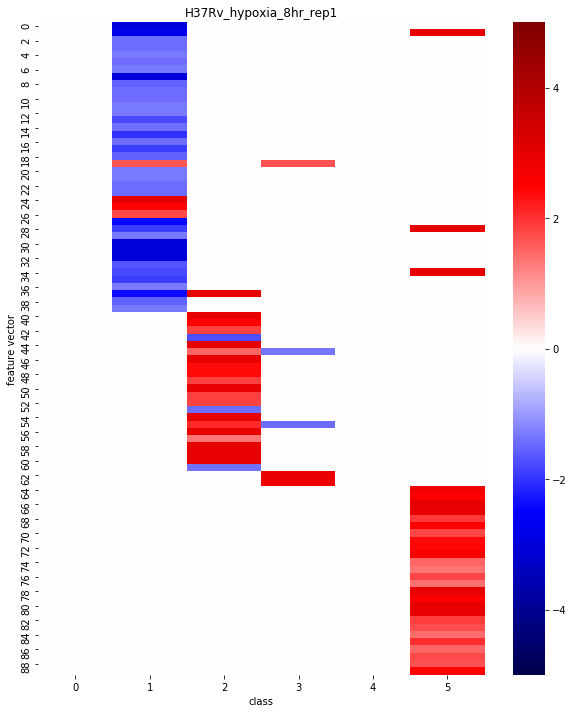

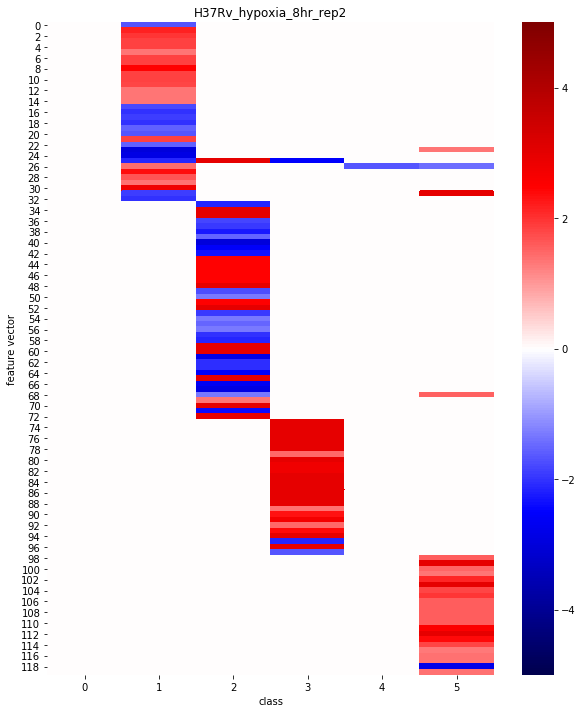

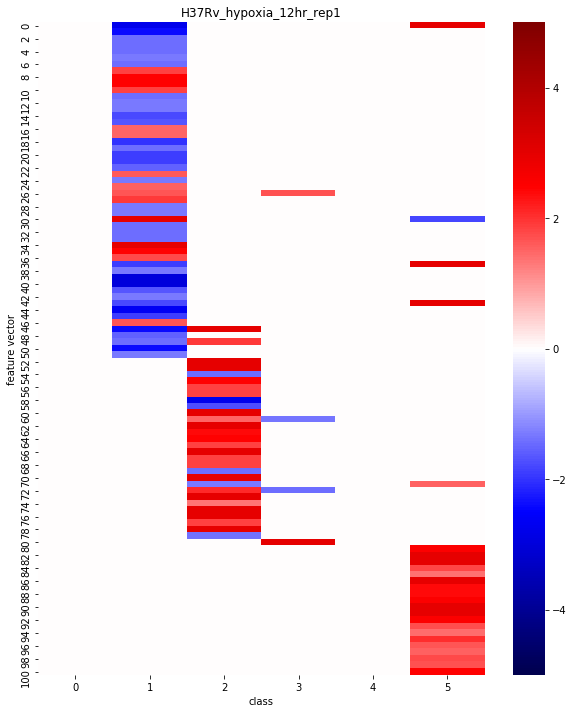

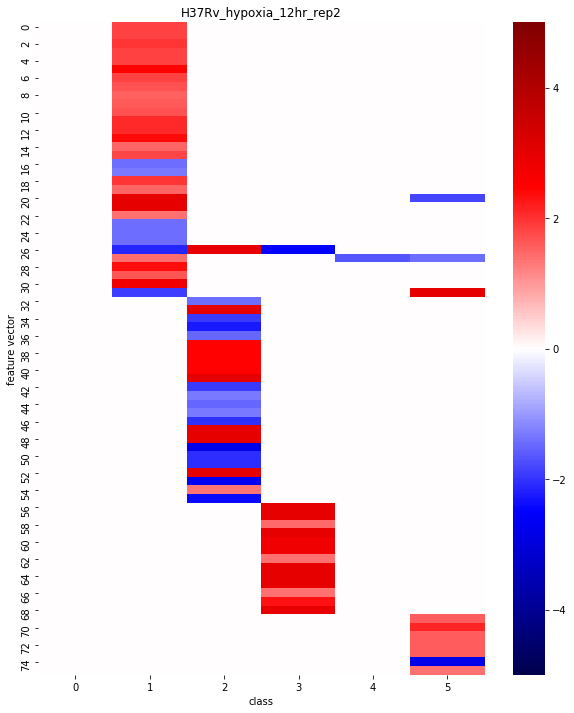

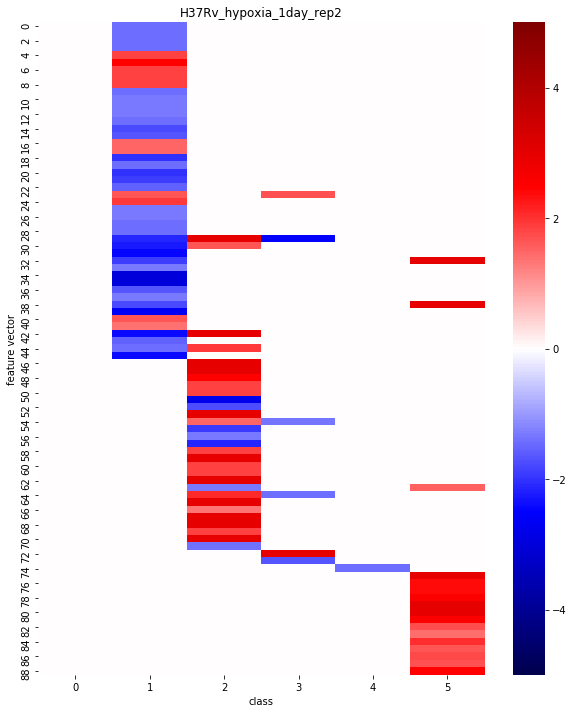

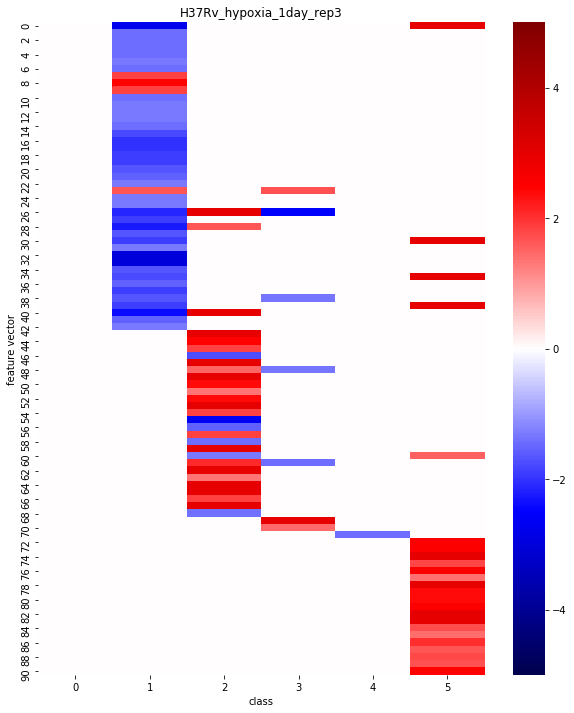

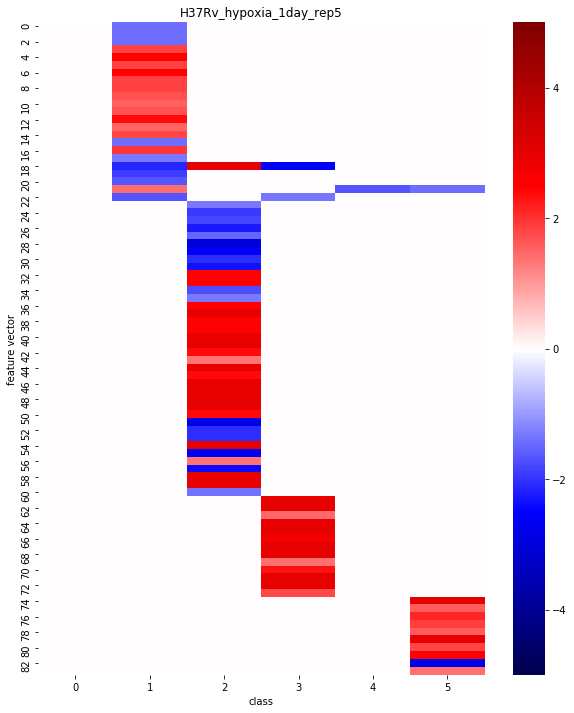

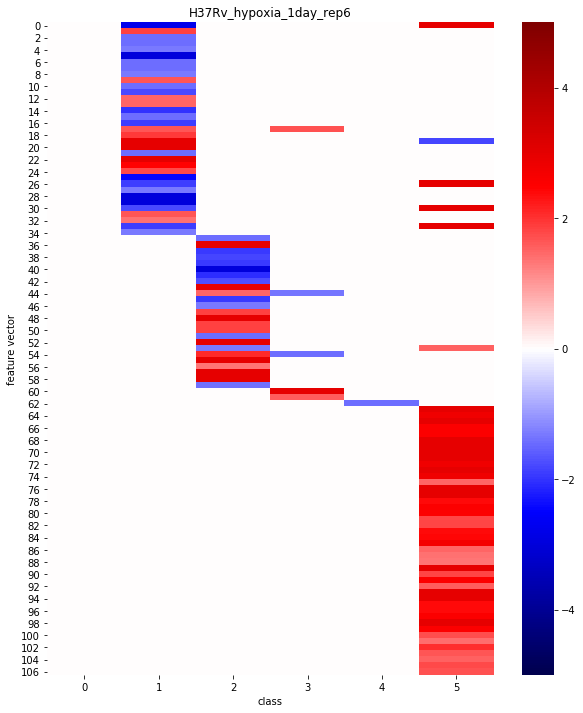

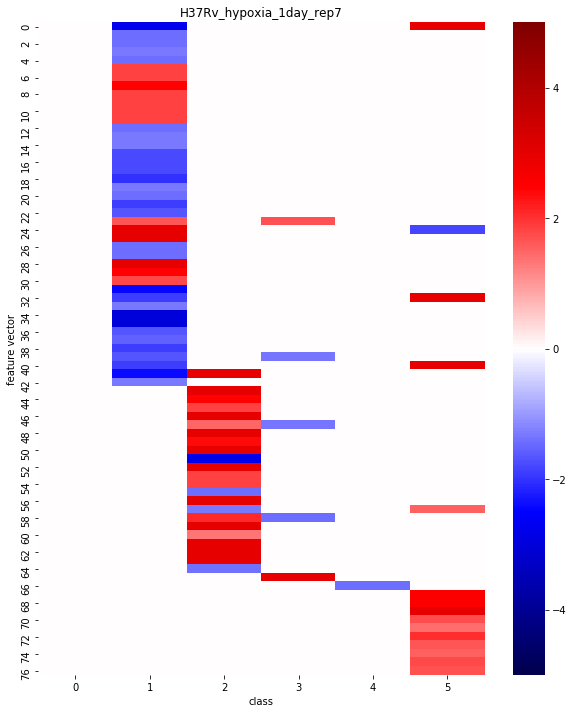

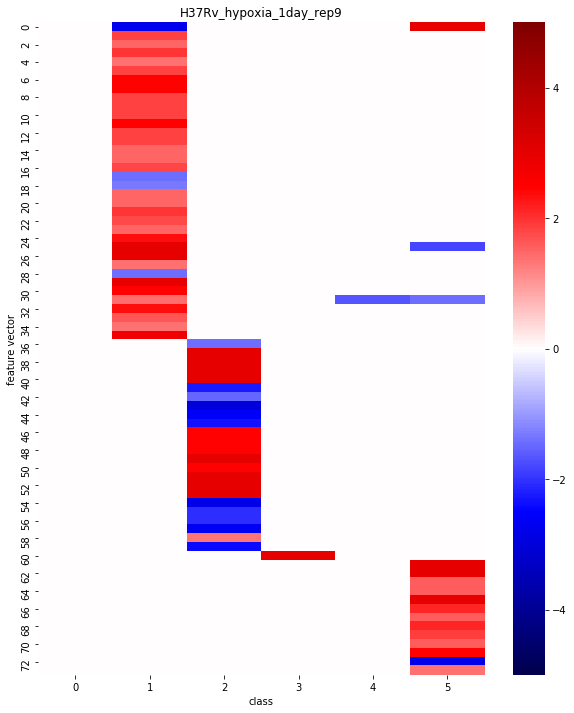

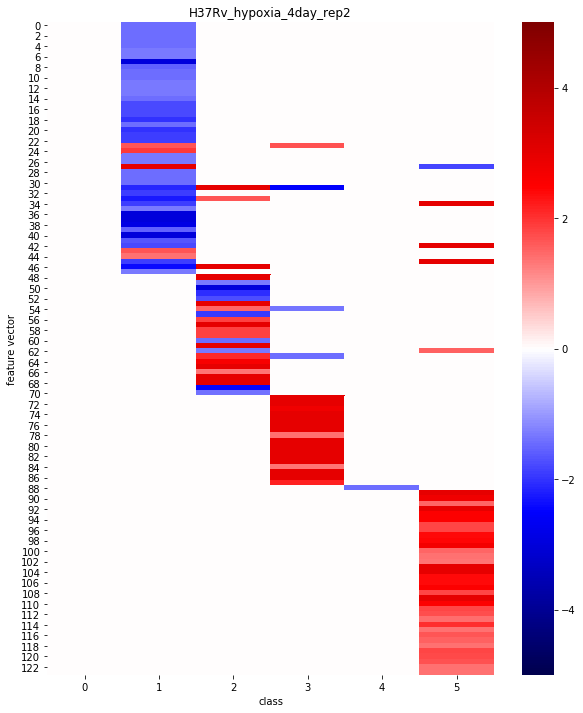

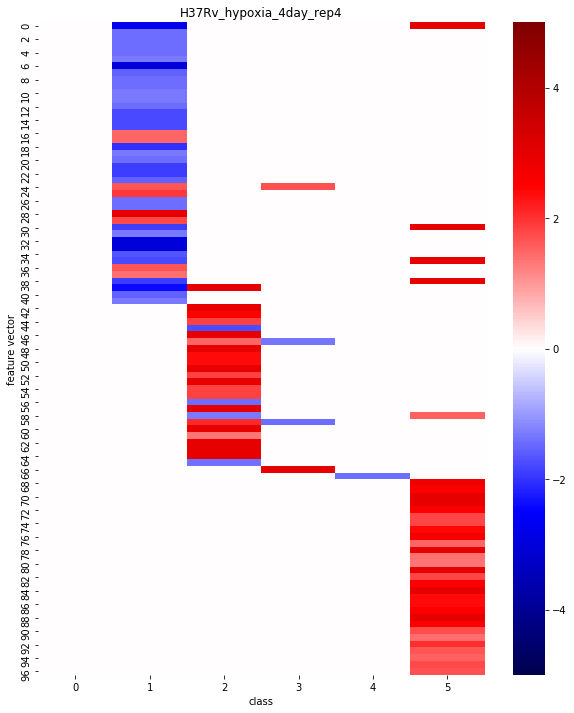

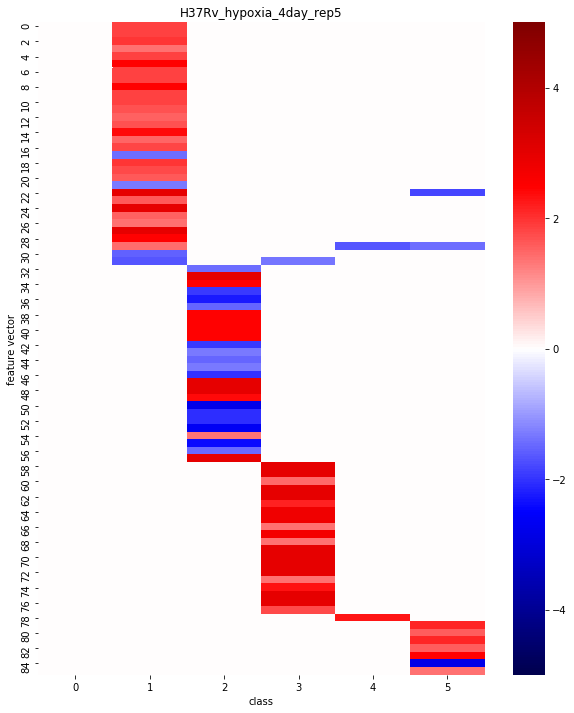

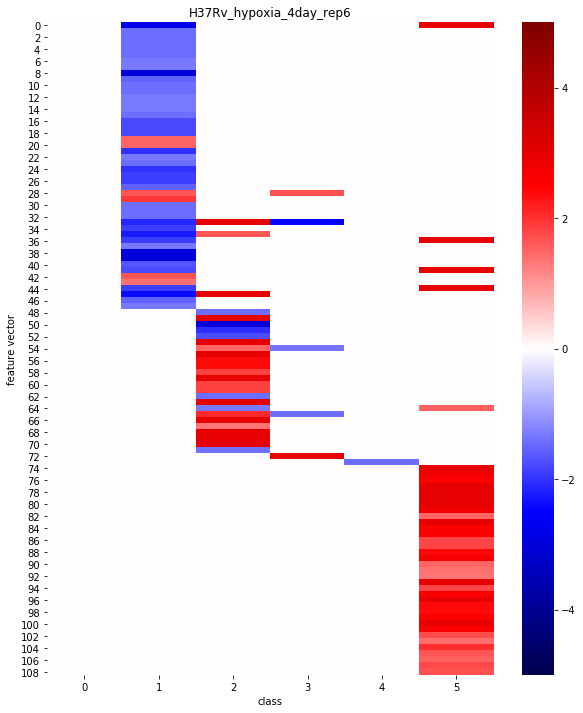

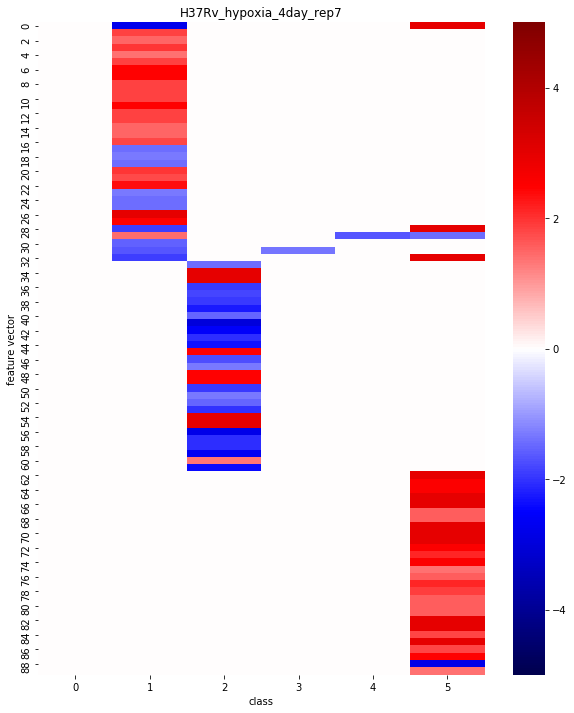

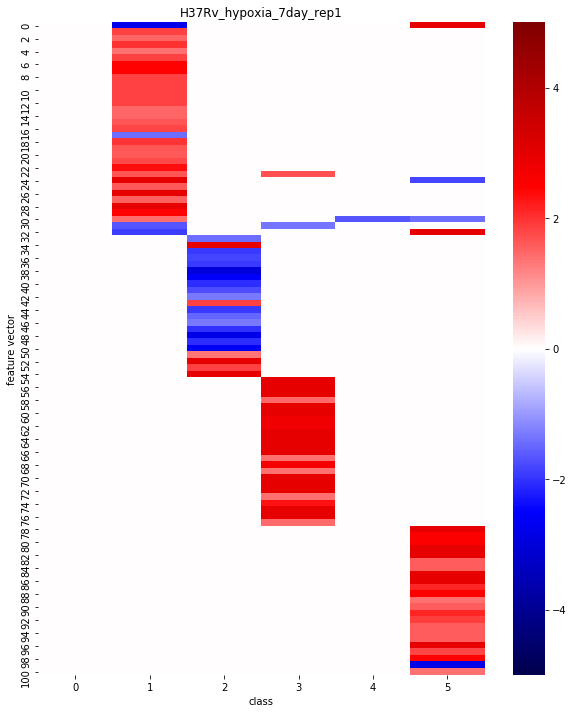

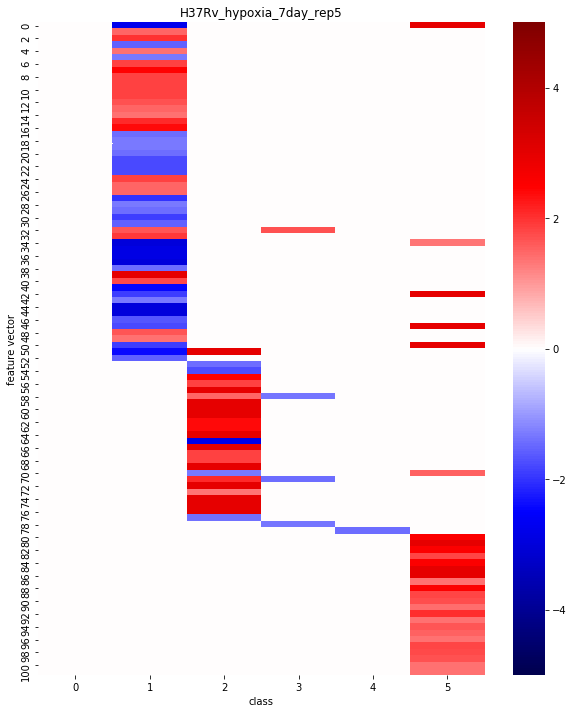

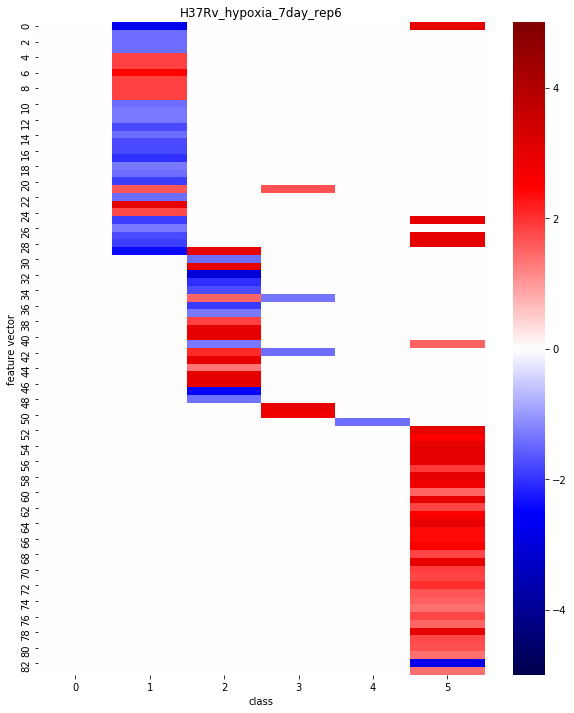

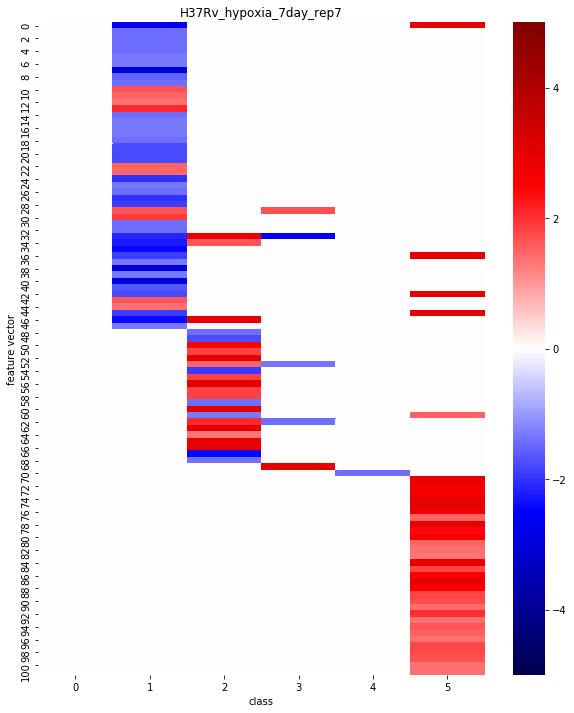

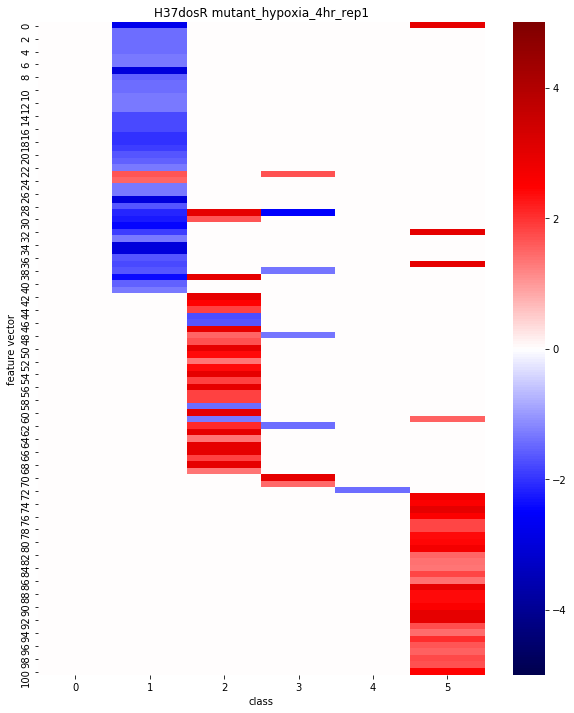

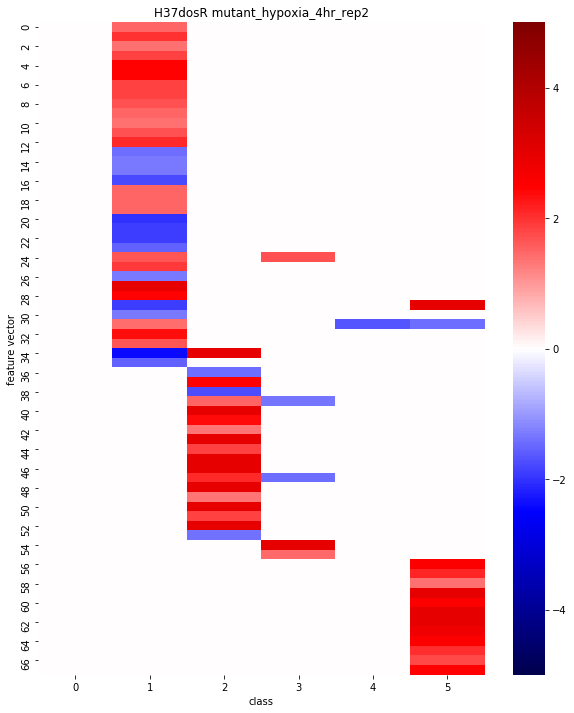

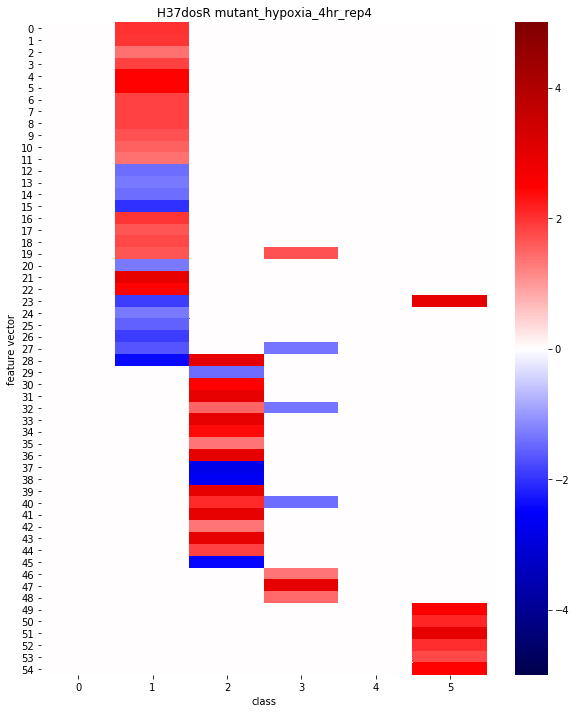

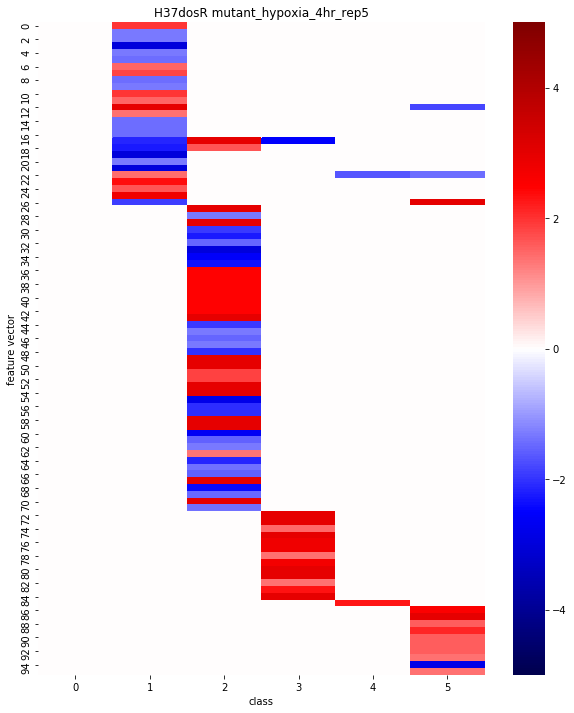

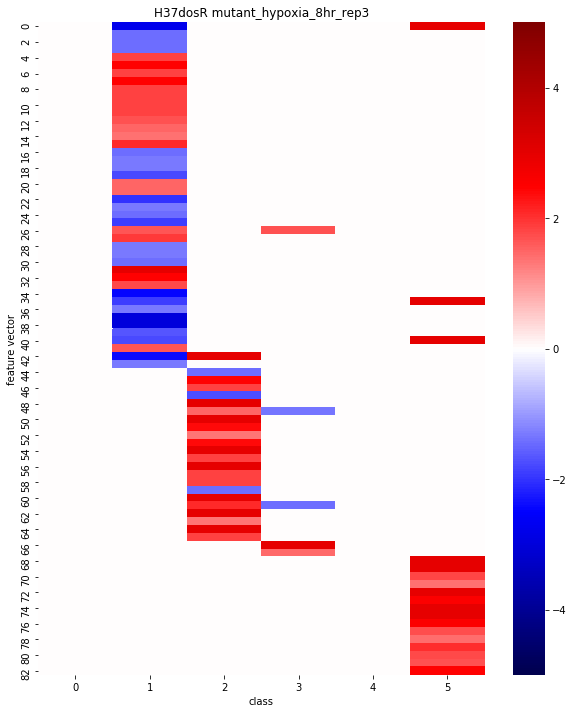

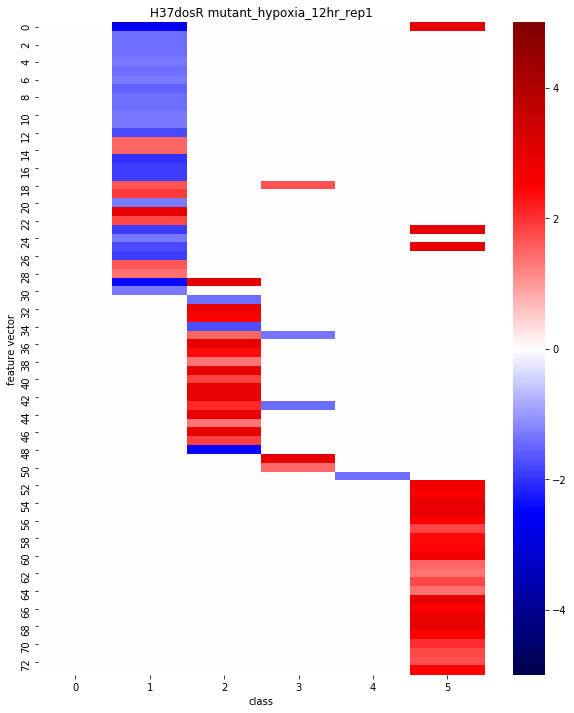

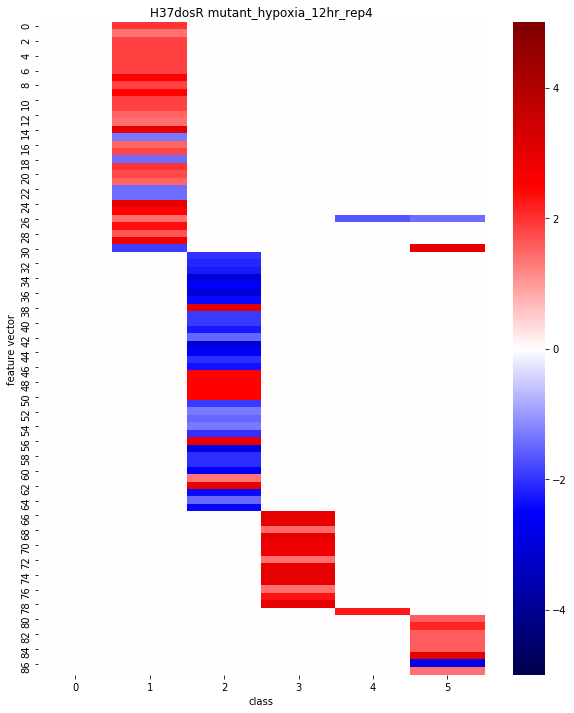

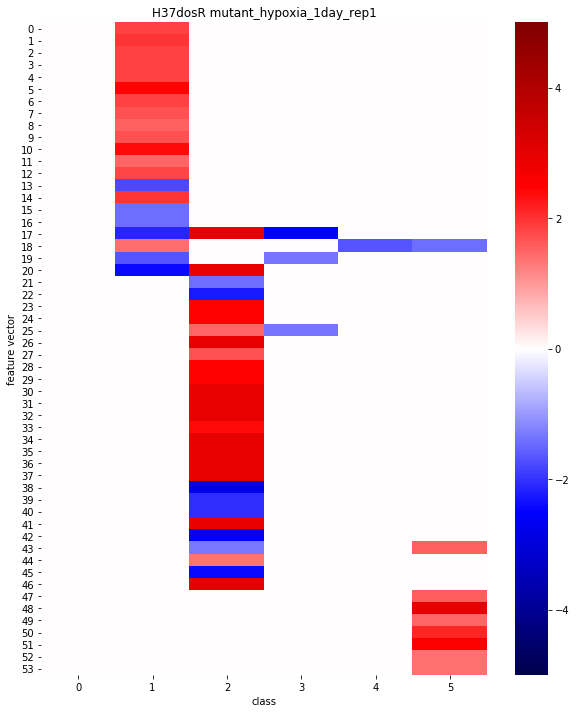

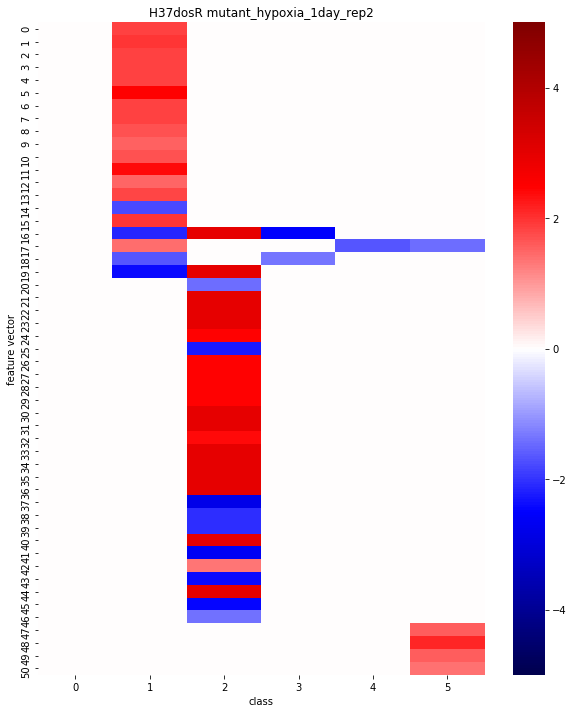

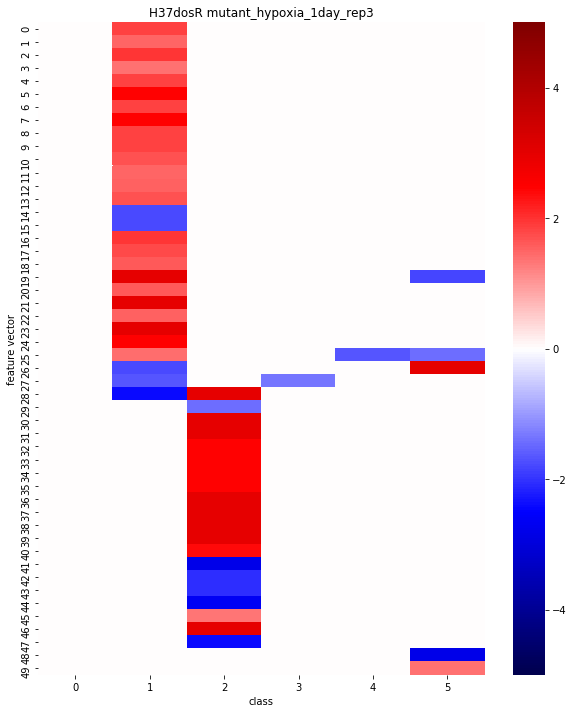

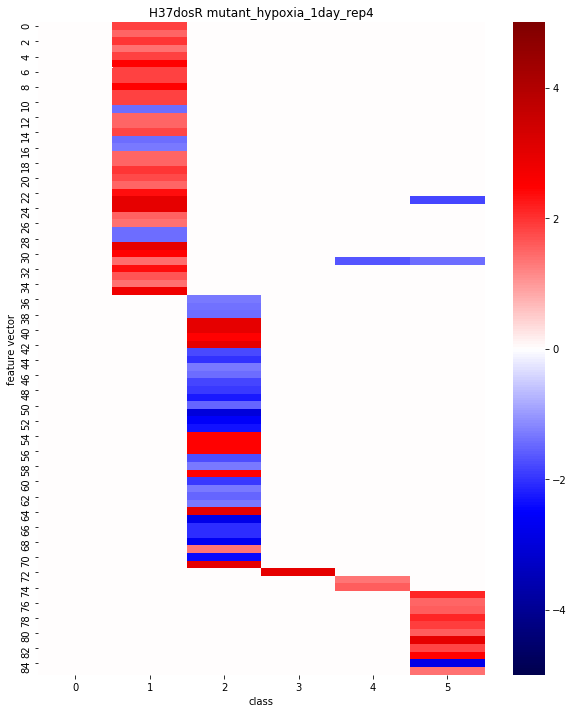

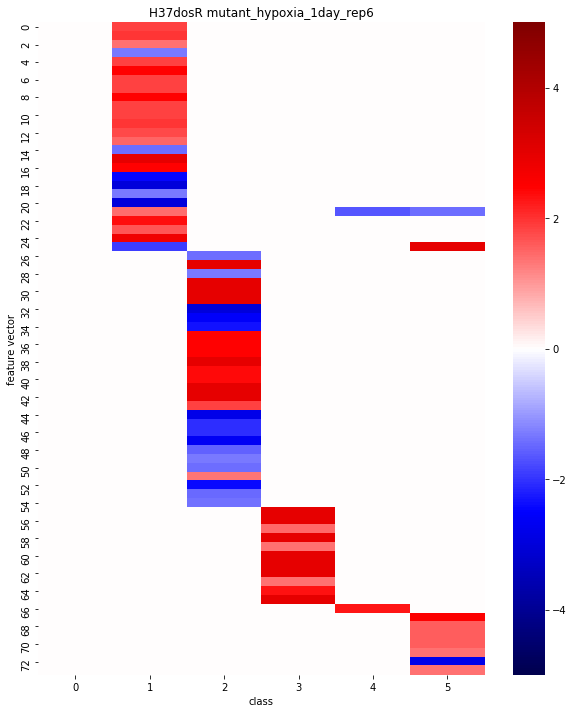

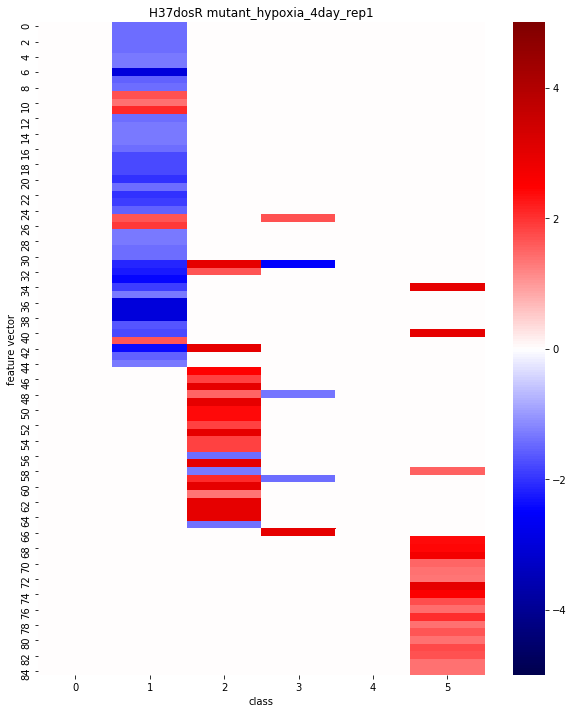

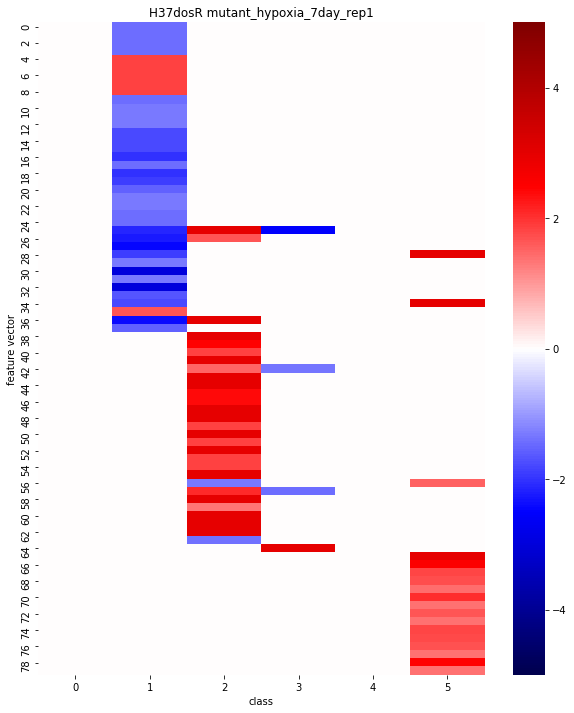

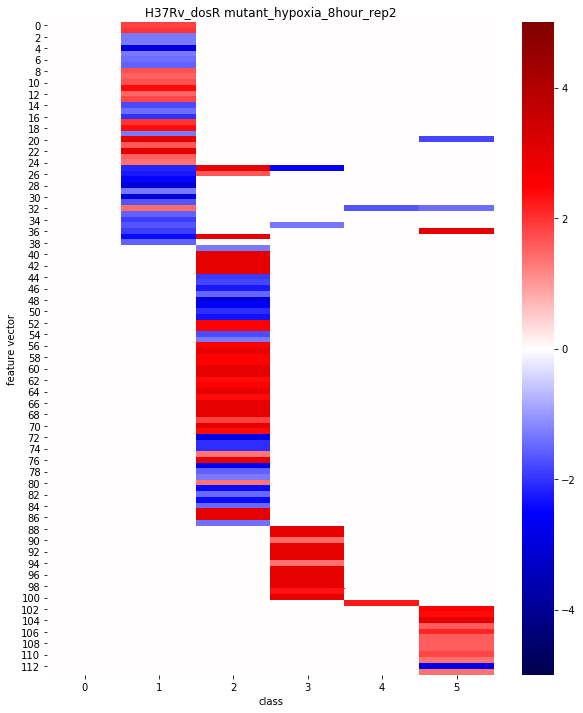

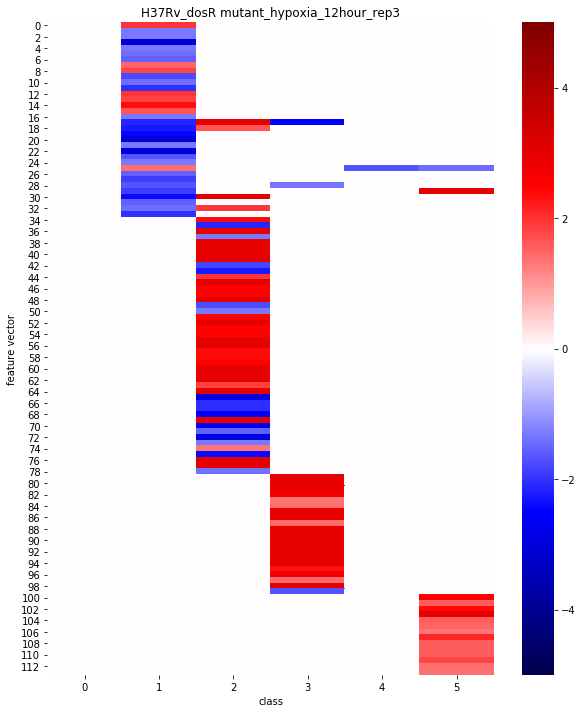

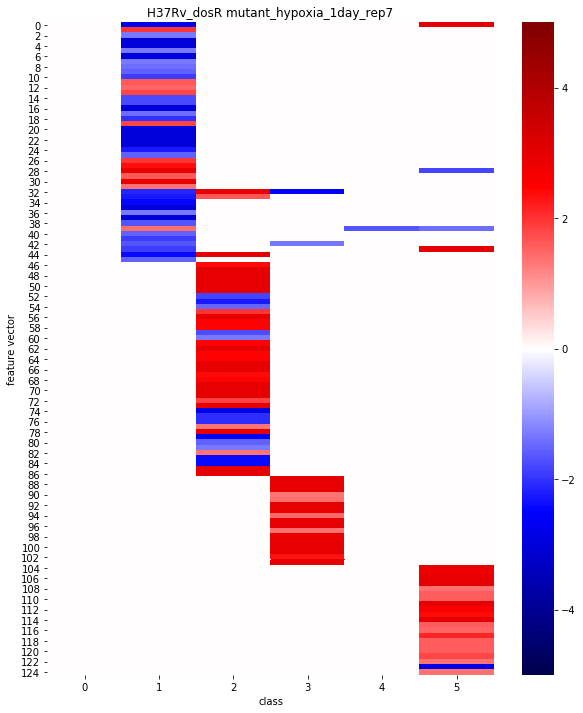

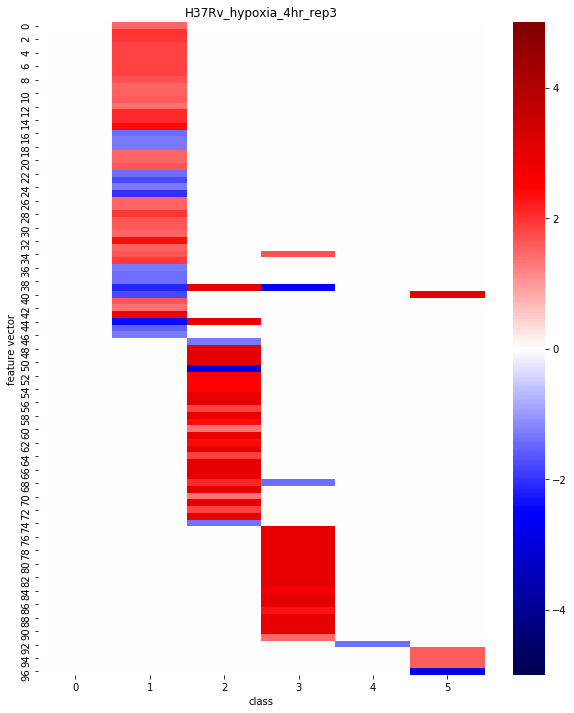

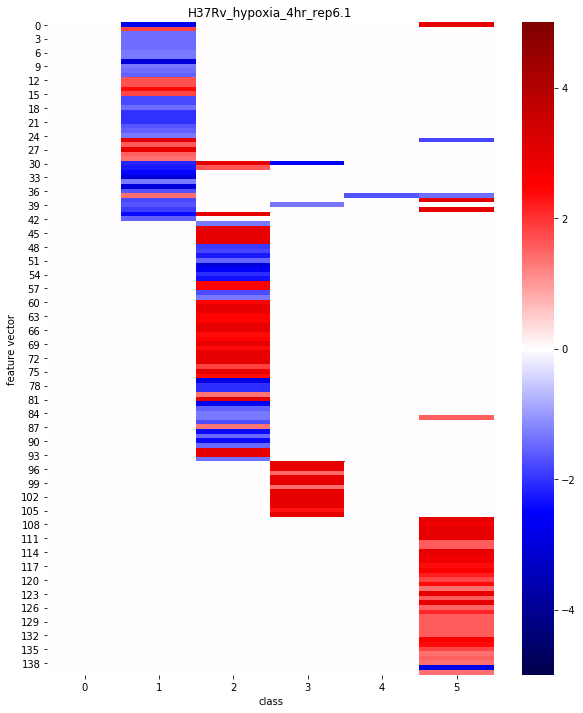

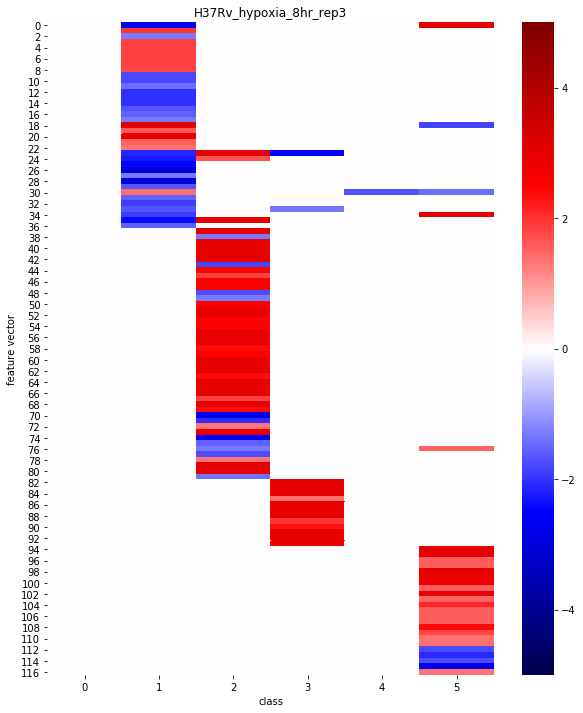

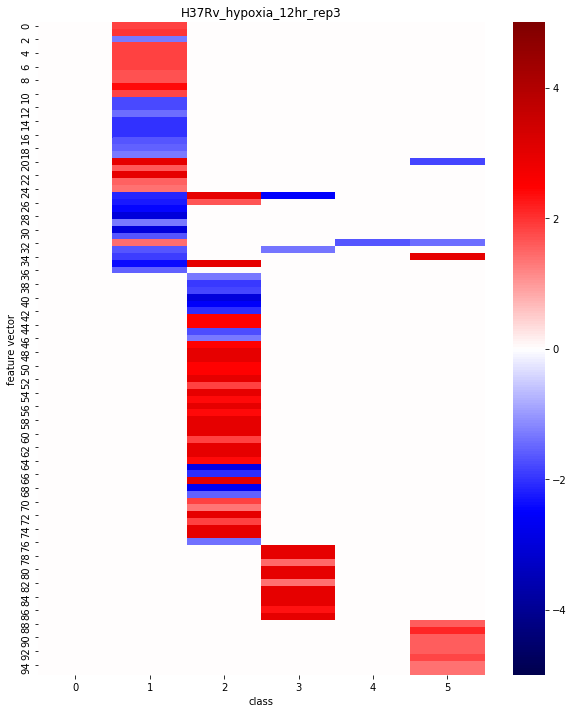

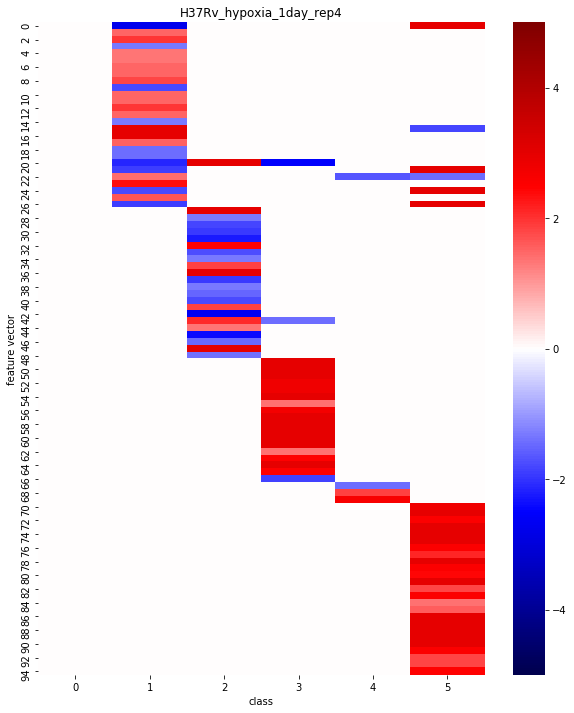

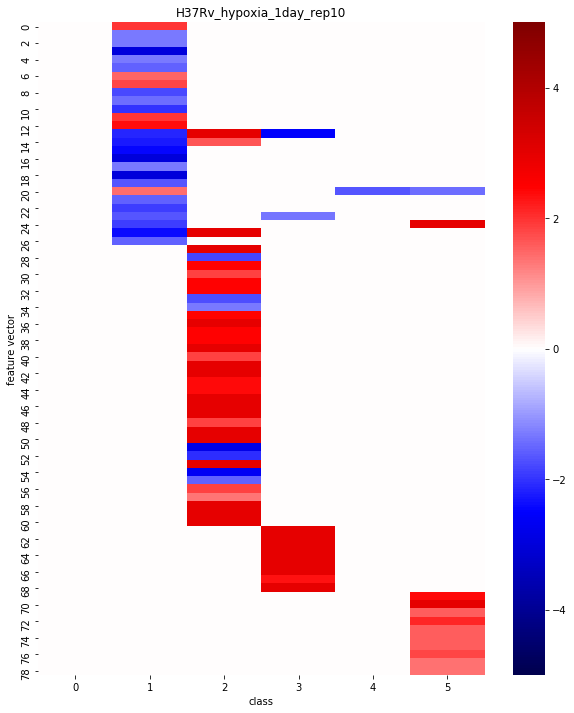

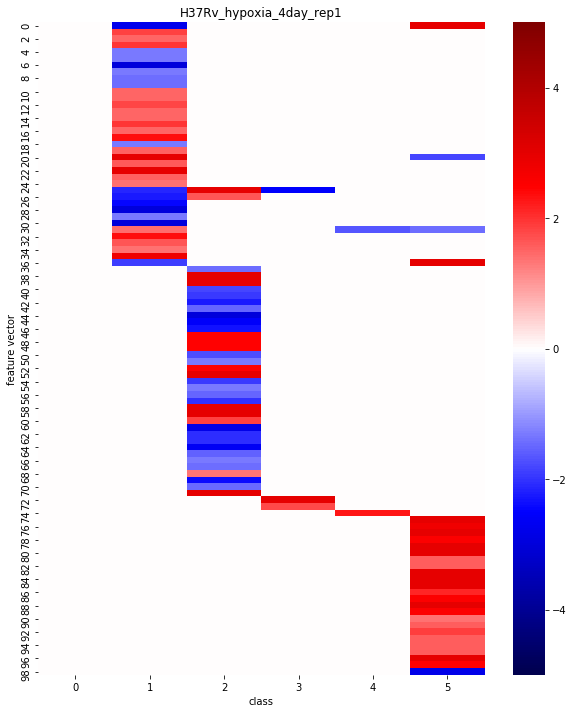

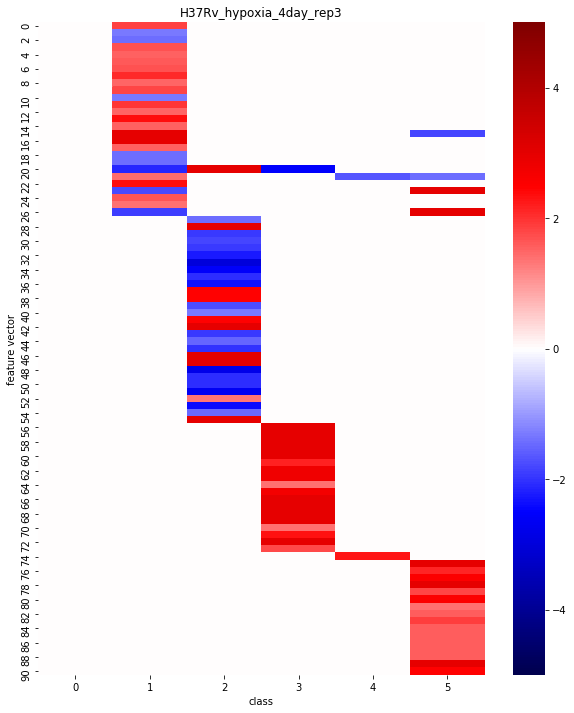

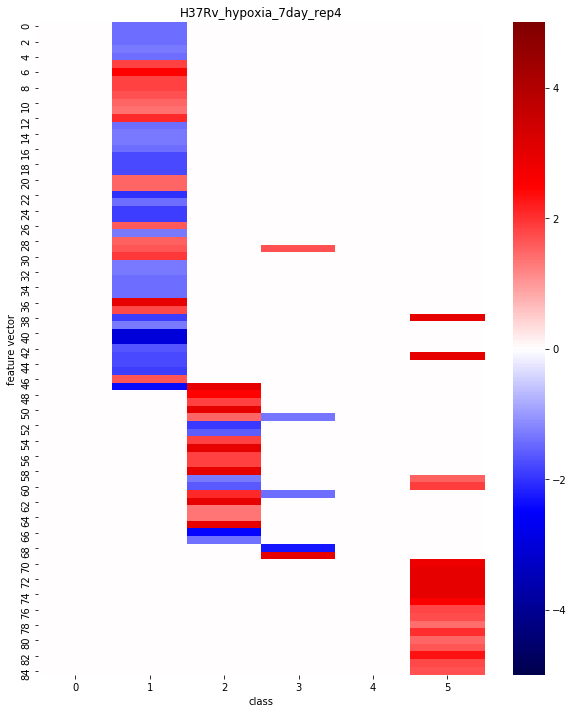

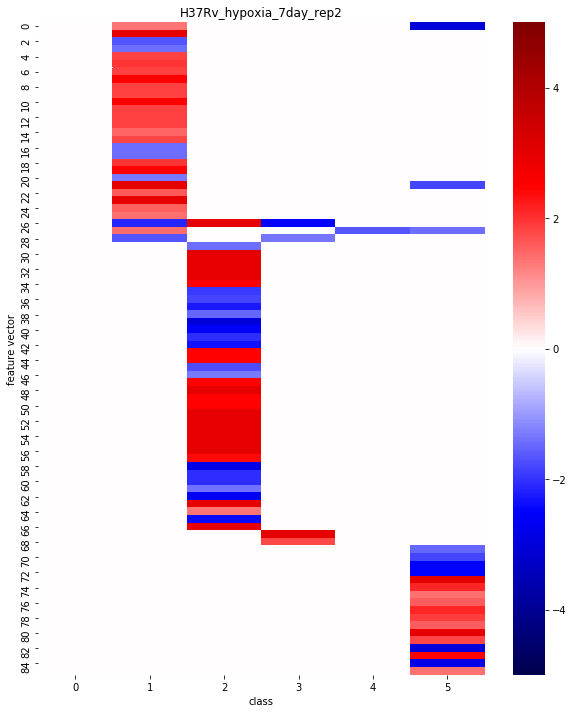

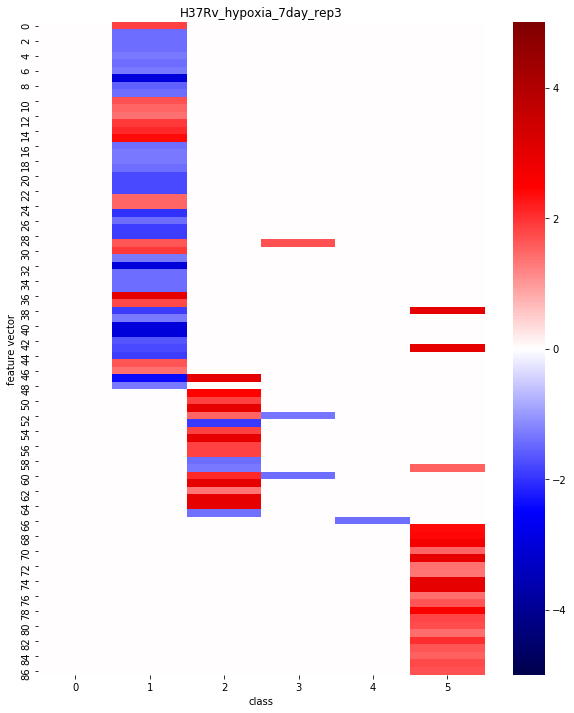

In [59]:
for instance in DF_RUSTAD.columns:
    fullProfile(DF_RUSTAD[instance], title=instance)

# Evaluations of Samples - Only "hypoxia"

In [60]:
CASE_MANAGER_DCT = copy.deepcopy(CASE_MANAGER_BASE_DCT)

NameError: name 'CASE_MANAGER_BASE_DCT' is not defined

In [ ]:
[m.filterCaseByDescription(SER_DESC, include_terms=["hypoxia"]) for m in CASE_MANAGER_DCT.values()]
{k: len(CASE_MANAGER_DCT[k].case_dct) for k in CASE_MANAGER_DCT}

## Training Data

In [ ]:
# Below is a evaluation of the feature vector at the first replication at time T3.
instances = ["T3.0", "T3.1", "T3.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

In [ ]:
instances = ["T13.0", "T13.1", "T13.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)
print("State: %s" % STATE_DCT[SER_Y.loc["T13.0"]])

## AW

In [ ]:
instances = [ ["AW_%s_%d" % (pm, n) for pm in ["plus", "neg"]] for n in [1, 3, 4]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AW[instance], title=instance)

## AM, MDM

In [ ]:
instances = [ ["%s_D20_%d" % (pm, n) for pm in ["AM", "MDM"]] for n in [1, 3, 4, 5]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AM_MDM[instance], title=instance)

# Next Steps

1. Use other criteria to select the cases
   1. Prefer longer feature vectors since more specific
   1. Remove correlated cases
   1. Filter feature vectors?
   1. Evaluate using counts of pos/neg cases by class